In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

from apps import cex_toy_generator, cex_toy_parameters
from IPython.display import clear_output
from python.analysis.Master import DictToHDF5, ReadHDF5
from python.analysis import cross_section, Plots
from scipy.stats import norm, lognorm
from statsmodels.stats.weightstats import ztest as ztest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.SetPlotStyle(True, 80)

def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball"):
    return {
    "events" : events,
    "step" : 2,
    "p_init" : p_init,
    "beam_profile" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs
    }


def RegionFitToyStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, energy_slice : cross_section.Slices, mean_track_score_bins : np.array = None, pdf : Plots.PlotBook = Plots.PlotBook.null):

    fit_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)
    result = cross_section.RegionFit.Fit(observed, model, False)

    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    #* split post fit results by the observables
    if mean_track_score_bins is not None:
        KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit")
    else:
        KE_int_prediction = postfit_pred

    total_count_err = np.sum(np.power(KE_int_prediction.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(KE_int_prediction.model_yields)

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    counts_matrix = []
    for j in toy.truth_region_labels:
        counts = []
        for i in toy.reco_region_labels:
            counts.append(sum(toy.NInteract(energy_slice, toy.truth_regions[j], toy.reco_regions[i])))
        counts_matrix.append(counts)
    print(f"{counts_matrix=}")
    total_count_actual = np.sum(counts_matrix)
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False)
    next(plot)
    counts_matrix = []
    for c in KE_int_prediction.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "fitted", newFigure = False)

    print(f"{total_count_actual, total_count, total_count_err=}")

    pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"${n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result


def ModifiedConfigTest(config : dict, energy_slice : cross_section.Slices, model : cross_section.pyhf.Model, toy_template : cross_section.Toy, pdf_name : str = None, mean_track_score_bins : np.array = None):
    if pdf_name is not None:
        pdf = Plots.PlotBook(pdf_name)
        pdf.open()
    else:
        pdf = Plots.PlotBook.null

    toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config))))
    
    obs = cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, mean_track_score_bins, model, False)
    fit_result = cross_section.RegionFit.Fit(obs, model, None, par_bounds = [(0, np.inf)]*model.config.npars)

    true_process_counts = {}
    for v in toy_alt_pdf.exclusive_process:
        true_process_counts[v] = sum(toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[v]))

    expected_mus = [sum(toy_alt_pdf.exclusive_process[r]) / sum(toy_template.truth_regions[r]) for r in toy_alt_pdf.exclusive_process]

    if pdf_name is not None: Plots.plt.close("all")
    return fit_result, true_process_counts, expected_mus


def NormalisationFractionalError(results, true_counts, model, toy_template):
    true_counts_pred_res = {}
    true_counts_pred_res_err = {}
    for k, v in results.items():
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")

        if any([c["name"] == "mean_track_score" for c in post_fit_pred.model.spec["channels"]]):
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score
        else:
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(0, len(post_fit_pred.model_yields)), "KE_int_postfit")

        true_counts_pred_res_err[k] = np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1]
        true_counts_pred_res[k] = {toy_template.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_template.reco_region_labels))])) - true_counts[k][toy_template.truth_region_labels[j]] for j in range(len(toy_template.truth_region_labels))}

    true_counts = pd.DataFrame(true_counts)
    true_counts_pred_res = pd.DataFrame(true_counts_pred_res)
    true_counts_pred_res_err = pd.DataFrame(true_counts_pred_res_err, index = true_counts_pred_res.index)

    return true_counts_pred_res / true_counts, true_counts_pred_res_err / true_counts


def EstimateBackground(fit_results, model, toy_template, signal_process : str):
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = fit_results)

    if any([c["name"] == "mean_track_score" for c in postfit_pred.model.spec["channels"]]):
        KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score
    else:
        KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(postfit_pred, slice(0, len(postfit_pred.model_yields)), "KE_int_postfit")

    L = np.sum(KE_int_prediction.model_yields, 0)

    L_err = KE_int_prediction.total_stdev_model_bins[:, :-1] # last entry in the array is the total error for the whole channel (but we want the total error in each process)
    L_err = np.sqrt(np.sum(L_err **2, 0)) # quadrature sum across all bins

    labels = list(toy_template.reco_region_labels) #! make property of AnalysisInput dataclass
    L_var_bkg = sum(L_err[signal_process != np.array(labels)]**2)
    L_bkg = sum(L[signal_process != np.array(labels)])

    return L_bkg, L_var_bkg


def BSFractionalError(model : cross_section.pyhf.Model, toy_template, fit_results, signal_process : str):
    b_fe = []
    b_fe_err = []
    s_fe = []
    s_fe_err = []
    for r in fit_results["results"]:
        bkg, bkg_var = EstimateBackground(fit_results["results"][r], model, toy_template, signal_process)    
        b_tc = sum([v for k, v in fit_results["true_counts"][r].items() if k != signal_process])
        
        b_fe.append((sum(bkg) - b_tc) / b_tc)
        b_fe_err.append(np.sqrt(sum(bkg_var)) / b_tc)

        n_total = sum([v for v in fit_results["true_counts"][r].values()])
        n_s = n_total - sum(bkg)
        n_s_err = np.sqrt(n_total + sum(bkg_var))
        s_tc = fit_results["true_counts"][r][signal_process]

        s_fe.append((n_s - s_tc) / s_tc)
        s_fe_err.append(n_s_err / s_tc)

    return (s_fe, s_fe_err), (b_fe, b_fe_err)


def PlotCrossCheckResults(xlabel, model : cross_section.pyhf.Model, toy_template : cross_section.Toy, results, true_counts, pdf : Plots.PlotBook = Plots.PlotBook.null):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    scale_factors = {k : sum(true_counts[k].values()) / sum(toy_template.df.total_inelastic) for k in true_counts}
    x = list(range(len(results)))

    mu = []
    mu_err = []
    for k in results:
        mu.append(results[k].bestfit[0:4] / scale_factors[k])
        mu_err.append(results[k].uncertainty[0:4] / scale_factors[k])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    process_map = {0 : "abs", 1 : "cex", 2 : "spip", 3 : "pip"}

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{{{process_map[i]}}}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
    Plots.plt.xticks(ticks = x, labels = results.keys())
    Plots.plt.xlabel(xlabel)
    pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, title = f"$\mu_{{{process_map[i]}}}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    fractional_error, fractional_error_unc = NormalisationFractionalError(results, true_counts, model, toy_template)
    true_counts = pd.DataFrame(true_counts)

    prefit_counts = [model.main_model.expected_data(np.array(model.config.suggested_init()) * scale_factors[k], return_by_sample = True) for k in scale_factors]

    if "mean_track_score" in model.config.channels:
        prefit_counts = [i[:, :-model.config.channel_nbins["mean_track_score"]] for i in prefit_counts]
    prefit_counts = np.array([np.sum(i, 1) for i in prefit_counts]).T


    # plot true process residual
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(x, true_counts.loc[i] * fractional_error.loc[i], yerr = true_counts.loc[i] * fractional_error_unc.loc[i], title = f"$N_{{{process_map[n]}}}^{{pred}}$", xlabel = xlabel, ylabel = "residual", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(x, fractional_error.loc[i], yerr = fractional_error_unc.loc[i], title = f"measured $N_{{{process_map[n]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(x, fractional_error.loc[i], yerr = fractional_error_unc.loc[i], title = f"$N_{{{process_map[n]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[n], label = "measured", newFigure = False)
        Plots.Plot(x, (prefit_counts[n] - true_counts.loc[i]) / true_counts.loc[i], title = f"$N_{{{process_map[n]}}}$", linestyle = "", marker = "o", color = "k", label = "prefit", newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    Plots.plt.figure()
    for n, i in enumerate(true_counts.index):
        Plots.Plot(x, fractional_error.loc[i], yerr = fractional_error_unc.loc[i], label = f"${process_map[n]}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        plt.ylim(-1, 1)
    Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [12]:
toy_template = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_cb_template.hdf5")

In [13]:
# energy_range = [1000, 2000]
energy_range = [0, 1000]
energy_slice = cross_section.Slices(50, min(energy_range), max(energy_range), True)

energy_overflow = np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)

mean_track_score_bins = np.linspace(0, 1, 21, True)

model, templates_energy, tempalates_mean_track_score = cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, mean_track_score_bins, True, None, False)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [68]:
pseudo_experiment = model.make_pdf(cross_section.pyhf.tensorlib.astensor(model.config.suggested_init())).sample((100, ))

pulls = []
for e in pseudo_experiment:
    result = cross_section.RegionFit.Fit(e / 10, model, None, [(0, np.inf)]*4, False)
    pull = ((10 * result.bestfit) - model.config.suggested_init()) / (10 * result.uncertainty)
    pulls.append(pull)
pulls = np.array(pulls)

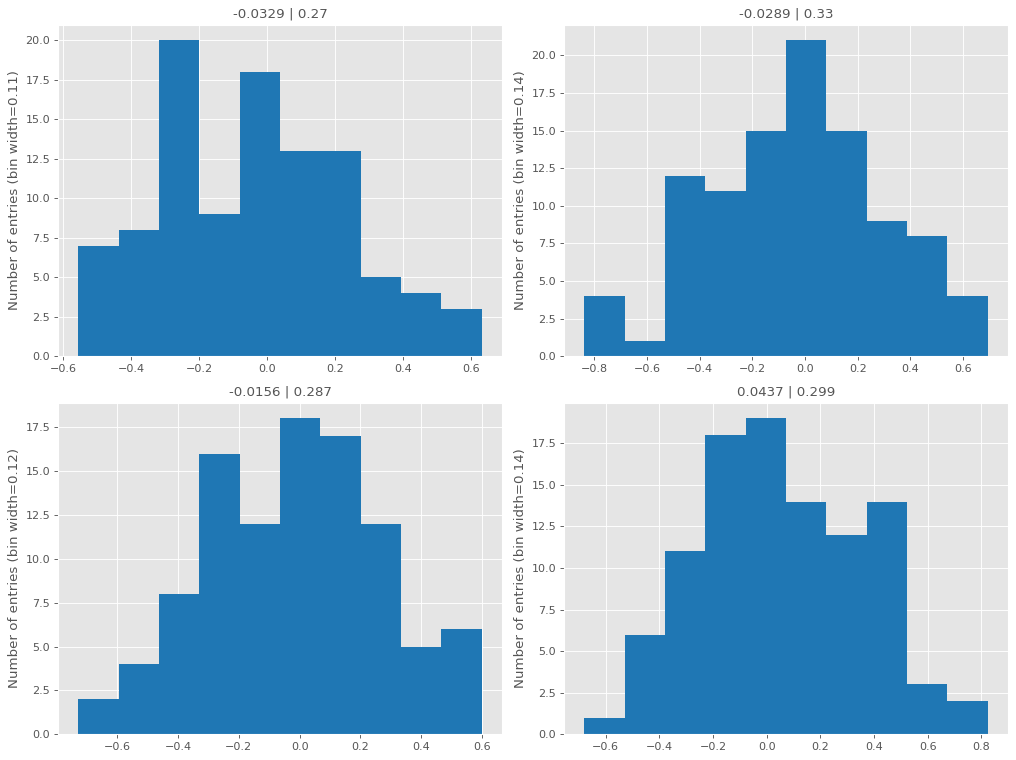

In [69]:
for i in Plots.MultiPlot(4):
    Plots.PlotHist(pulls[:, i], bins = 10, title = f"{np.mean(pulls[:, i]):.3g} | {np.std(pulls[:, i]):.3g}", newFigure = False)

# Templates

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


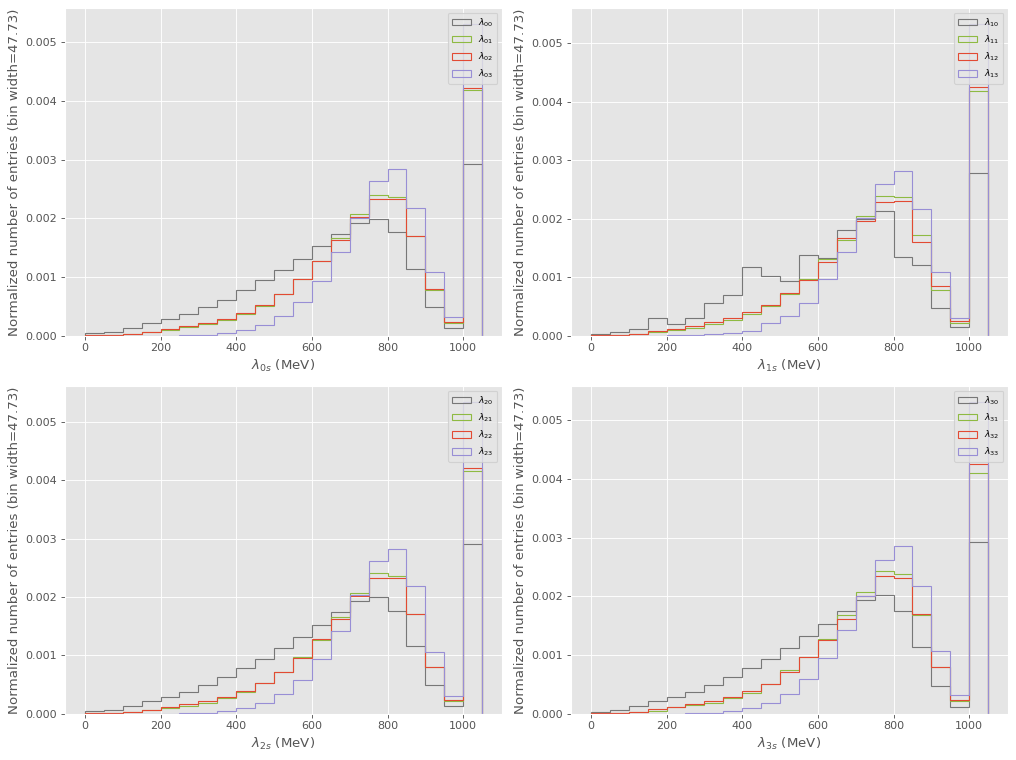

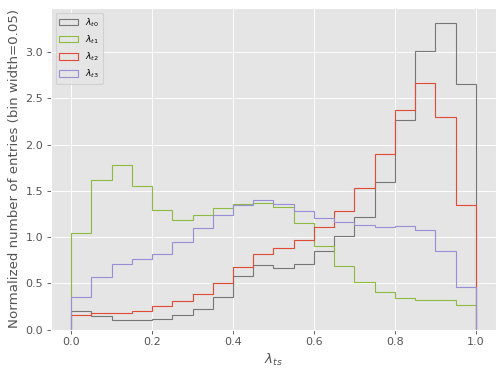

In [4]:
pdf = Plots.PlotBook("fit_templates.pdf", False)

tags = cross_section.Tags.ExclusiveProcessTags(toy_template.truth_regions)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(energy_overflow, energy_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = True)
pdf.Save()

plt.figure()
for i, s in enumerate(tempalates_mean_track_score):
    Plots.PlotHist(cross_section.bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
plt.legend(loc = "upper left")
pdf.Save()
pdf.close()

# Validation test

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-522.28890785])
init_params=False
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([1.00013775, 0.9994995 , 0.99984788, 1.00040049])
uncertainty=array([0.0018245 , 0.00332153, 0.00187331, 0.00495383])
result=FitResults(bestfit=array([1.00013775, 0.9994995 , 0.99984788, 1.00040049]), uncertainty=array([0.0018245 , 0.00332153, 0.00187331, 0.00495383]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.69022574 -0.58329556  0.41479101]
 [-0.69022574  1.          0.4705639  -0.60586613]
 [-0.58329556  0.4705639   1.         -0.84892524]
 [ 0.41479101 -0.60586613 -0.84892524  1.        ]], best_twice_nll=1044.5455933849205, goodness_of_fit=-1, minos_uncertainty={})


counts_matrix=[[2234453, 689, 546359, 104276], [1096987, 151664, 170206, 40808], [1601396, 21051, 2169314, 287859],
[673487, 48675, 577943, 202868]]

total_count_actual, total_count, total_count_err=(9928035, 9928035.271261547, 9309.712993558727)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.000138  0.999500  0.999848  1.000400
error  0.001824  0.003322  0.001873  0.004954

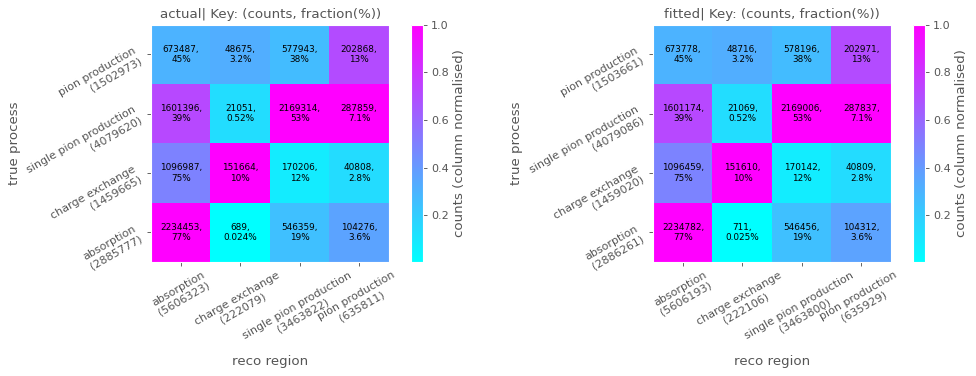

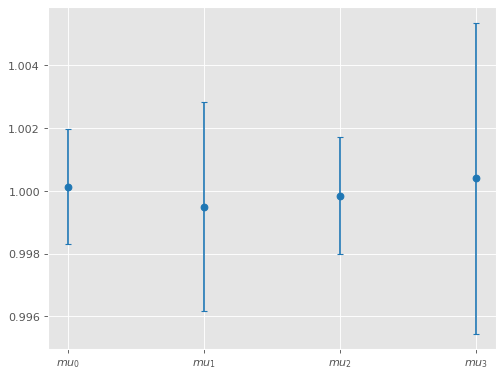

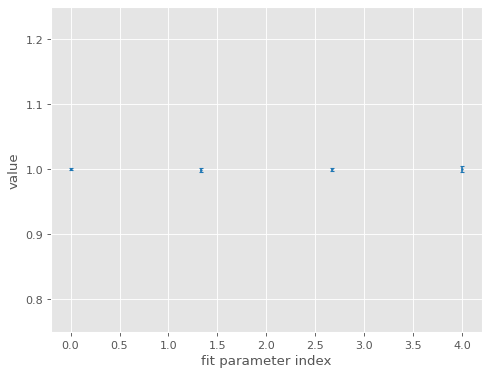

In [22]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitToyStudy(toy_template, model, energy_slice, None, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [56]:
toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1, events = 43035))))

Simulating |████████████████████████████████████████| 1/1 [100%] in 1.1s (0.89/s) 


'BeamSelectionEfficiency' executed in 0.0031s

'GenerateRecoRegions' executed in 0.0394s

'MeanTrackScore' executed in 0.2118s

'main' executed in 1.4814s

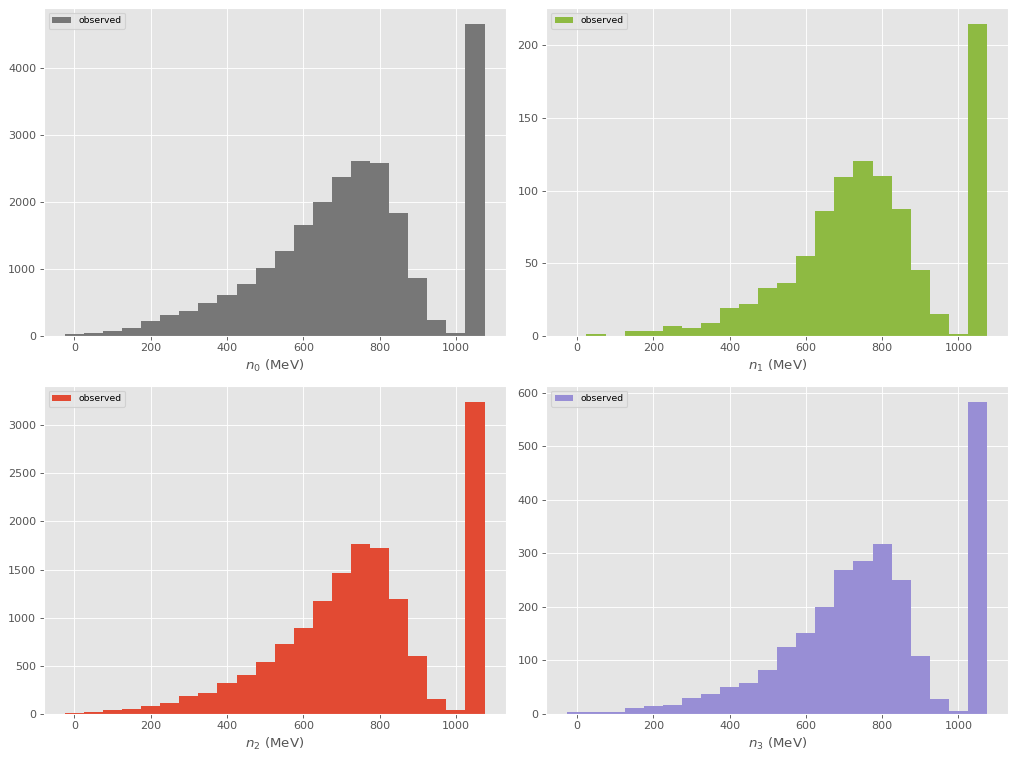

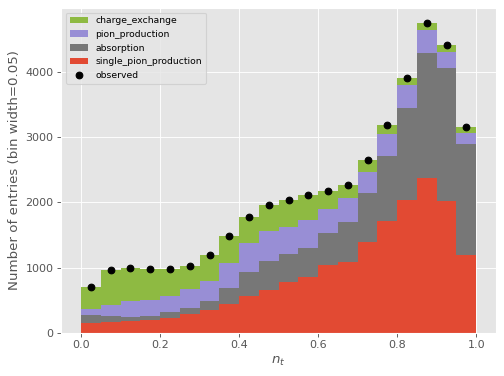

In [65]:
pdf = Plots.PlotBook("toy_observations.pdf", False)
tags = cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions)

n_obs = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, mean_track_score_bins)
n_obs_energy = n_obs[:-1]
n_obs_mean_track_score = n_obs[-1]
for i, r in Plots.IterMultiPlot(toy_observed.reco_region_labels):
    Plots.Plot(energy_overflow, n_obs_energy[i], xlabel = f"$n_{{{i}}}$ (MeV)", marker = "o", color = tags[r].colour, linestyle = "-", label = "observed", style = "bar", newFigure = False)
pdf.Save()

Plots.PlotTagged(toy_observed.df.mean_track_score, tags, mean_track_score_bins, norm = False)
Plots.Plot(cross_section.bin_centers(mean_track_score_bins), n_obs_mean_track_score, xlabel = "$n_{t}$", marker = "o", color = "black", linestyle = "", label = "observed", newFigure = False)
pdf.Save()
pdf.close()

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9653144.16904509])
init_params=False
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.00427331, 0.00456241, 0.00440933, 0.00382886])
uncertainty=array([0.00012036, 0.00021993, 0.00012376, 0.00032665])
result=FitResults(bestfit=array([0.00427331, 0.00456241, 0.00440933, 0.00382886]), uncertainty=array([0.00012036, 0.00021993, 0.00012376, 0.00032665]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.69496728 -0.58560383  0.42151893]
 [-0.69496728  1.          0.4751473  -0.60861544]
 [-0.58560383  0.4751473   1.         -0.85219828]
 [ 0.42151893 -0.60861544 -0.85219828  1.        ]], best_twice_nll=644.4443087719733, goodness_of_fit=-1, minos_uncertainty={})


counts_matrix=[[9704, 4, 2371, 454], [4667, 675, 737, 156], [7012, 100, 9387, 1205], [2821, 202, 2433, 808]]

total_count_actual, total_count, total_count_err=(42736, 42736.01447412585, 614.4274451349046)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.004273  0.004562  0.004409  0.003829
error  0.000120  0.000220  0.000124  0.000327

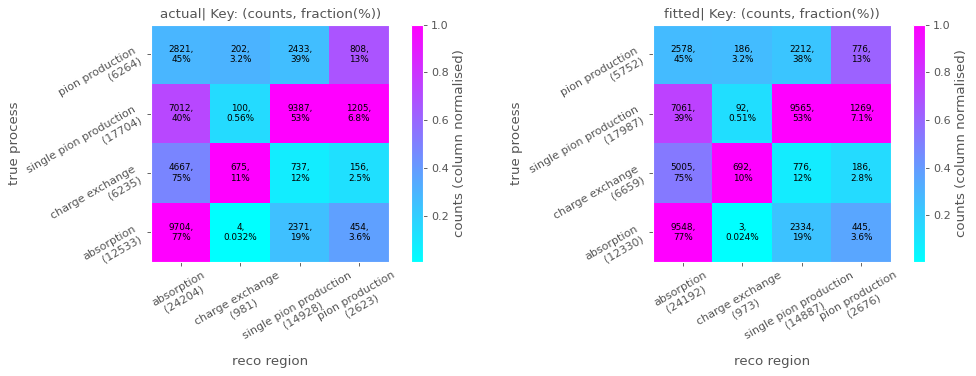

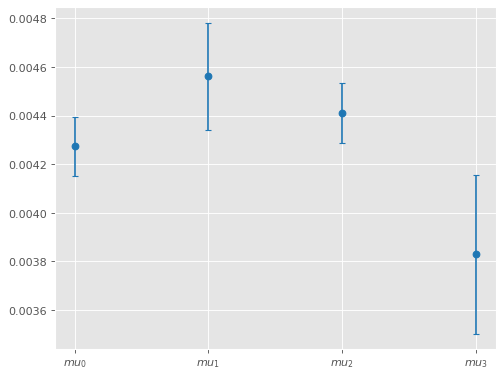

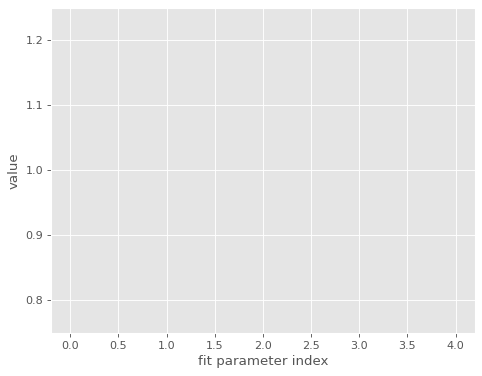

In [67]:
pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", False)
result = RegionFitToyStudy(toy_observed, model, energy_slice, None, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [6]:
toy_alt = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
fractions = cross_section.ReadHDF5("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_template.df.exclusive_process, fractions, np.random.default_rng())
toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.369524  
pion_production                0.129529

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.119524  
pion_production                0.379529

'GenerateRecoRegions' executed in 15.3544s

In [9]:
cross_section.AnalysisInput.CreateAnalysisInputToy(toy_alt)

RegionFit.FitInput(regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}, outside_tpc=array([False, False, False, ..., False, False, False]), KE_int=array([790.78735067, 855.76283972, 846.89393684, ..., 792.53907374,
       808.40776848, 726.85612174]), KE_init=array([878.43655808, 827.73892447, 934.21780807, ..., 922.71766467,
       939.86234677, 802.99491719]), mean_track_score=array([0.7491085464398641, 0.631785005006679, 0.548571686403099, ...,
       0.794598364795846, 0.4354737227453884, 0.8886725692151805],
      dtype=object))

fit_input.regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

counts_matrix=[[1826895, 570, 473524, 113995], [899530, 111561, 124753, 29515], [1423759, 15303, 1583047, 210654], 
[510551, 33788, 129983, 412788]]

total_count_actual, total_count, total_count_err=(7900216, 7898231.532061219, 11216.25780495737)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.391489  0.439683  0.451176  2.346546
error  0.002833  0.004277  0.003159  0.008264

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


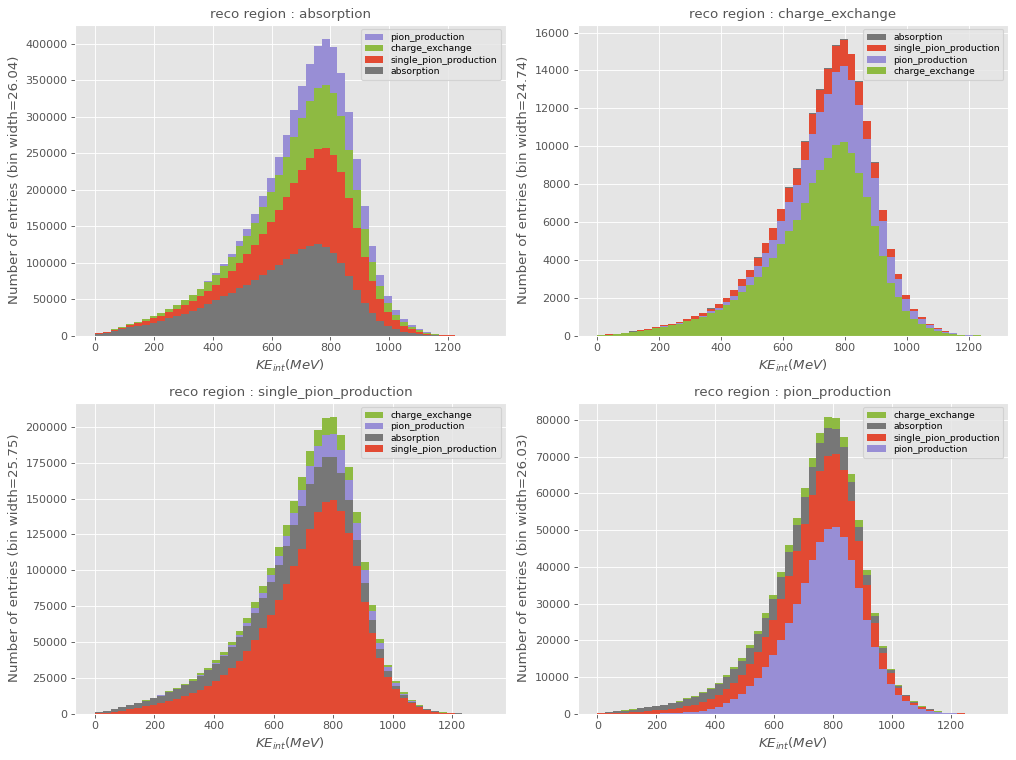

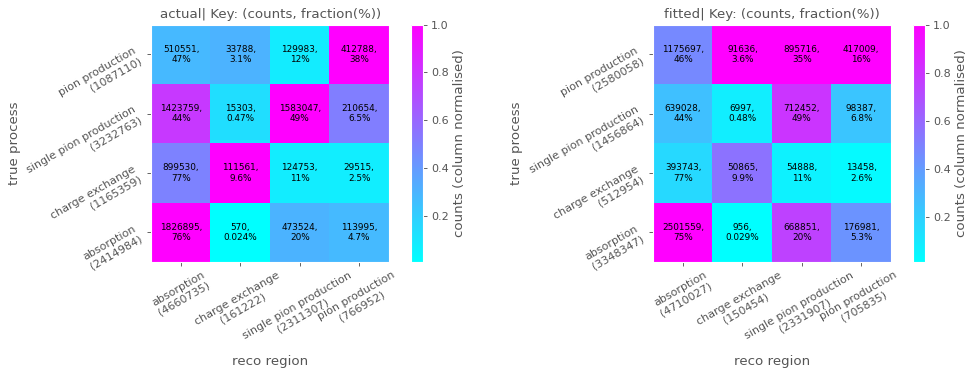

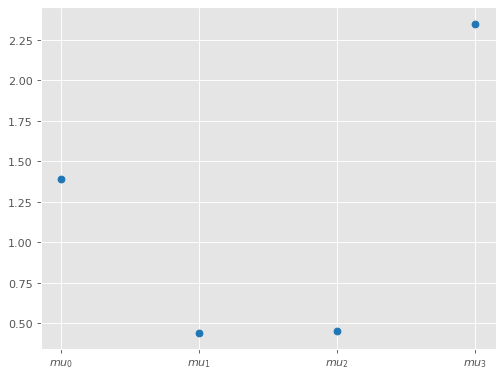

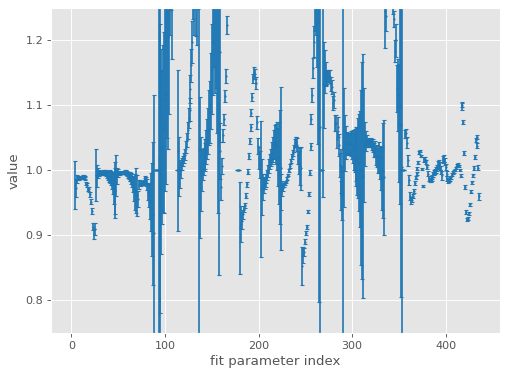

In [14]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled")
result = RegionFitToyStudy(toy_alt, model, energy_slice, mean_track_score_bins, pdf = pdf)
pdf.close()

# Modified exclusive process rates

In [5]:
def PlotObservedToy(scales : dict[int], config_args : dict):
    toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales, **config_args))))
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
    Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins)
    Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, histtype = "step", reverse_sort = True)

In [6]:
toy_data_config = {"PDSP" : 2, "p_init" : 2000, "seed" : 1, "events" : 43035}

## original PDFs

Simulating |████████████████████████████████████████| 1/1 [100%] in 5.0s (0.20/s) 


'BeamSelectionEfficiency' executed in 0.0088s

'GenerateRecoRegions' executed in 0.0794s

'MeanTrackScore' executed in 0.2762s

'main' executed in 5.5610s

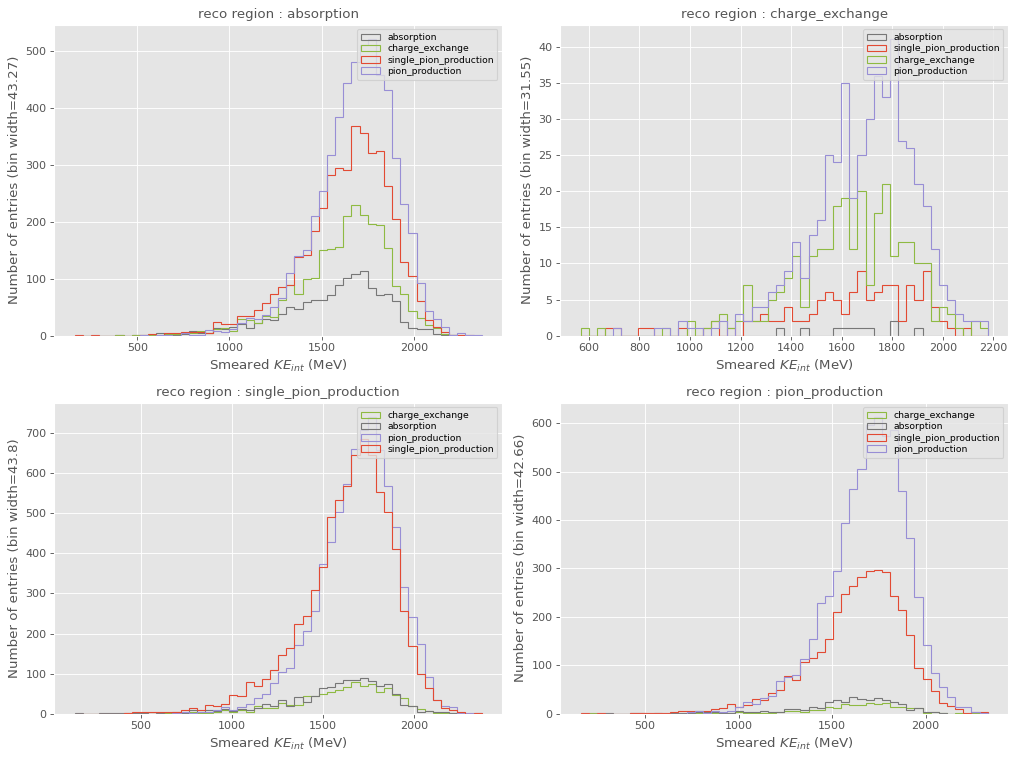

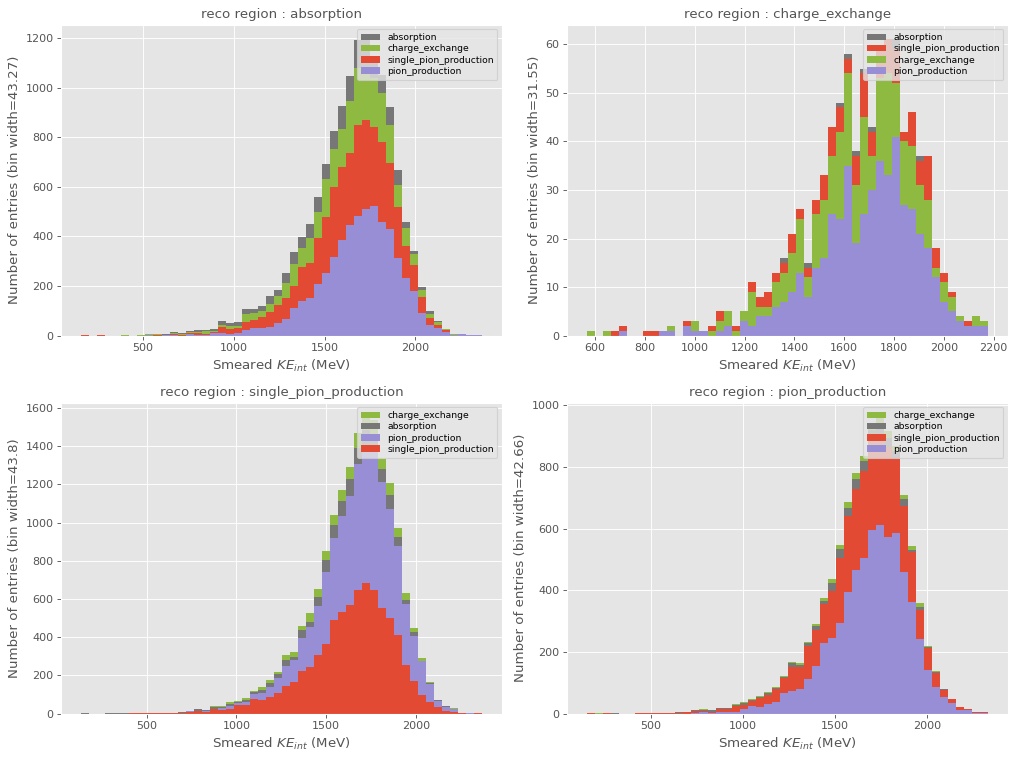

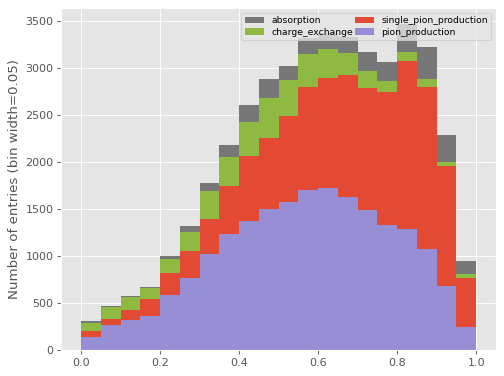

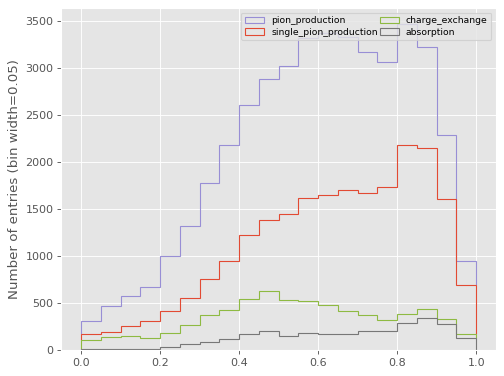

In [22]:
PlotObservedToy(None, toy_data_config)

## modified PDFs

Simulating |████████████████████████████████████████| 1/1 [100%] in 4.1s (0.24/s) 


'BeamSelectionEfficiency' executed in 0.0056s

'GenerateRecoRegions' executed in 0.0790s

'MeanTrackScore' executed in 0.3043s

'main' executed in 4.7102s

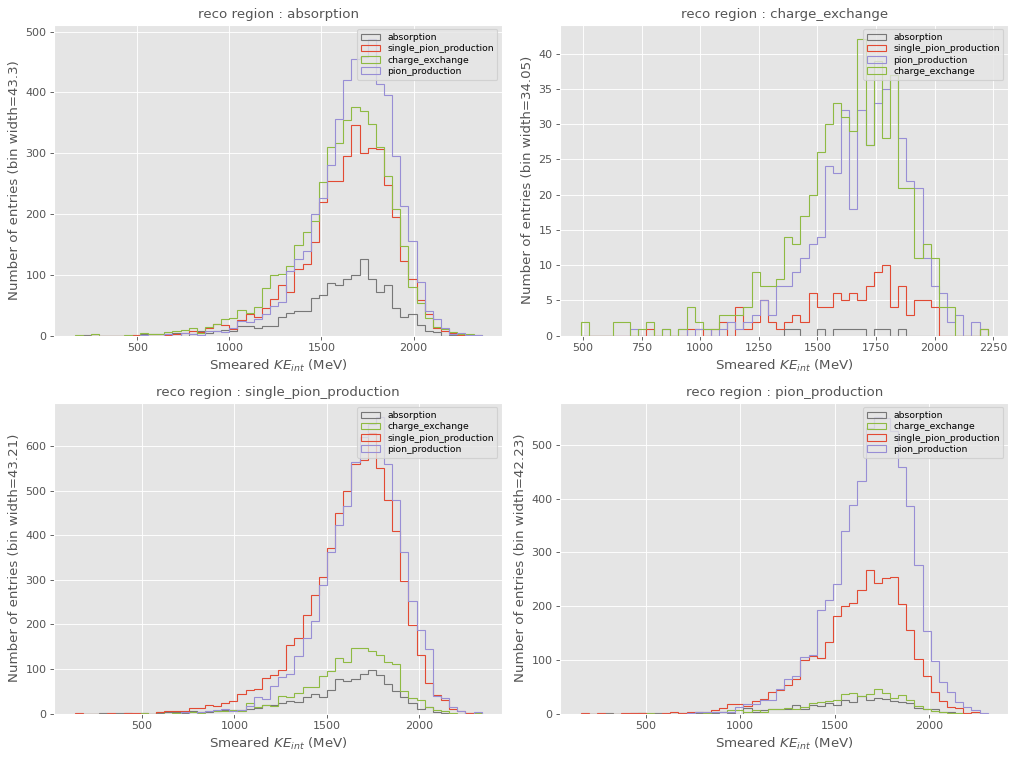

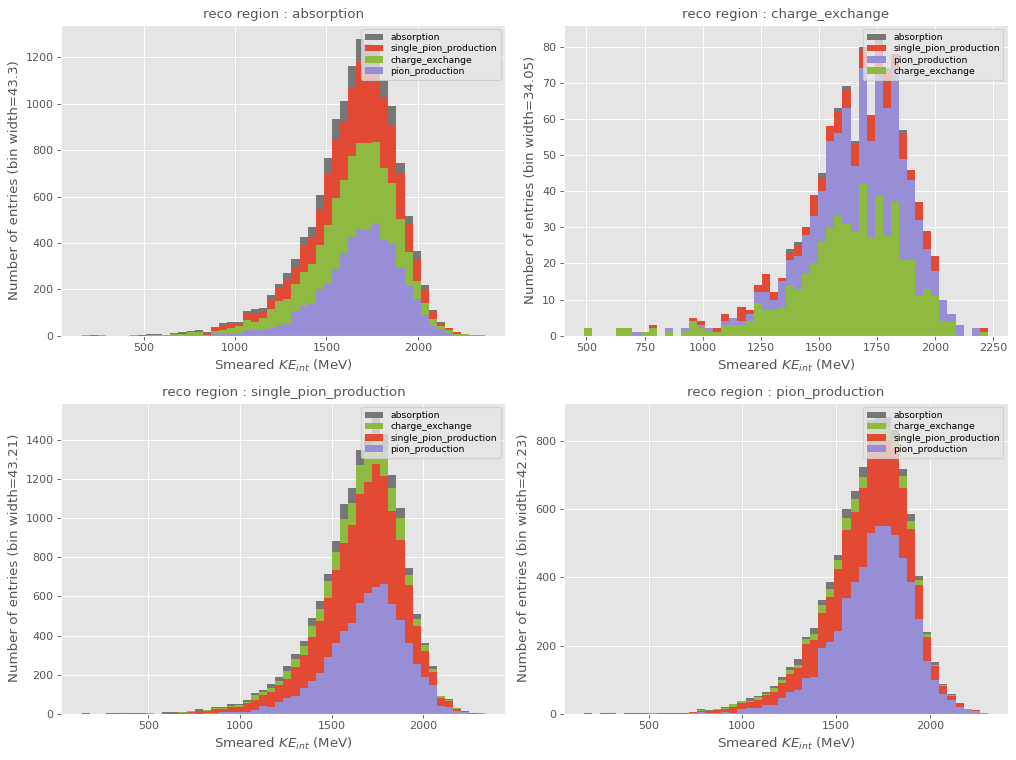

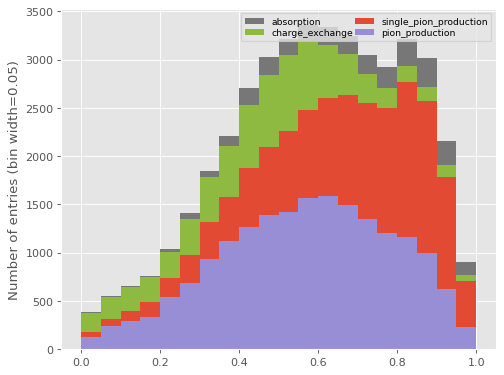

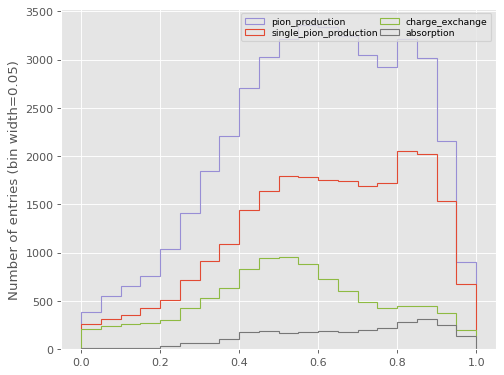

In [25]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 2,
    'double_charge_exchange': 1,
    'pion_production': 1
    }
PlotObservedToy(scales, toy_data_config)

## Compare shapes

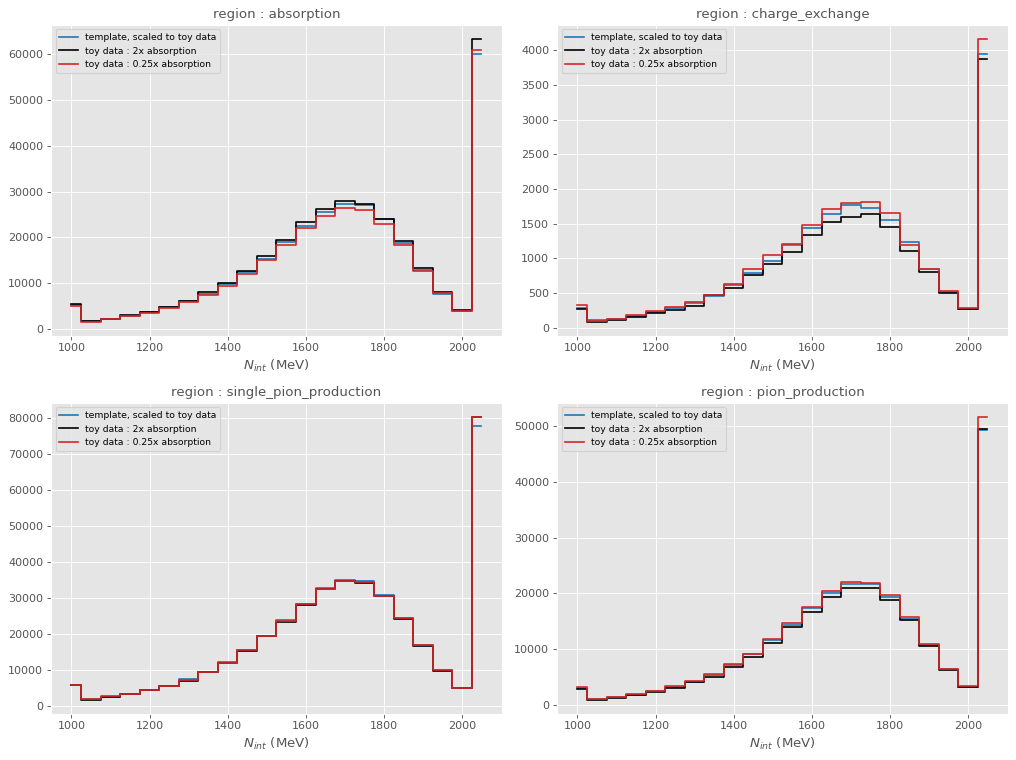

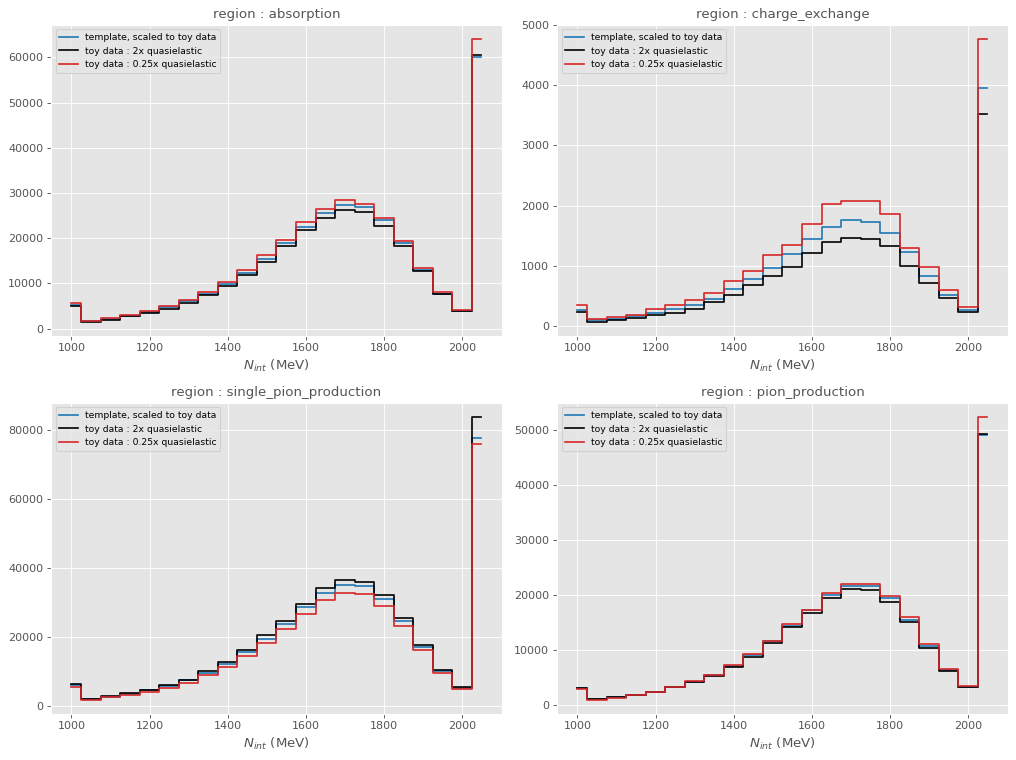

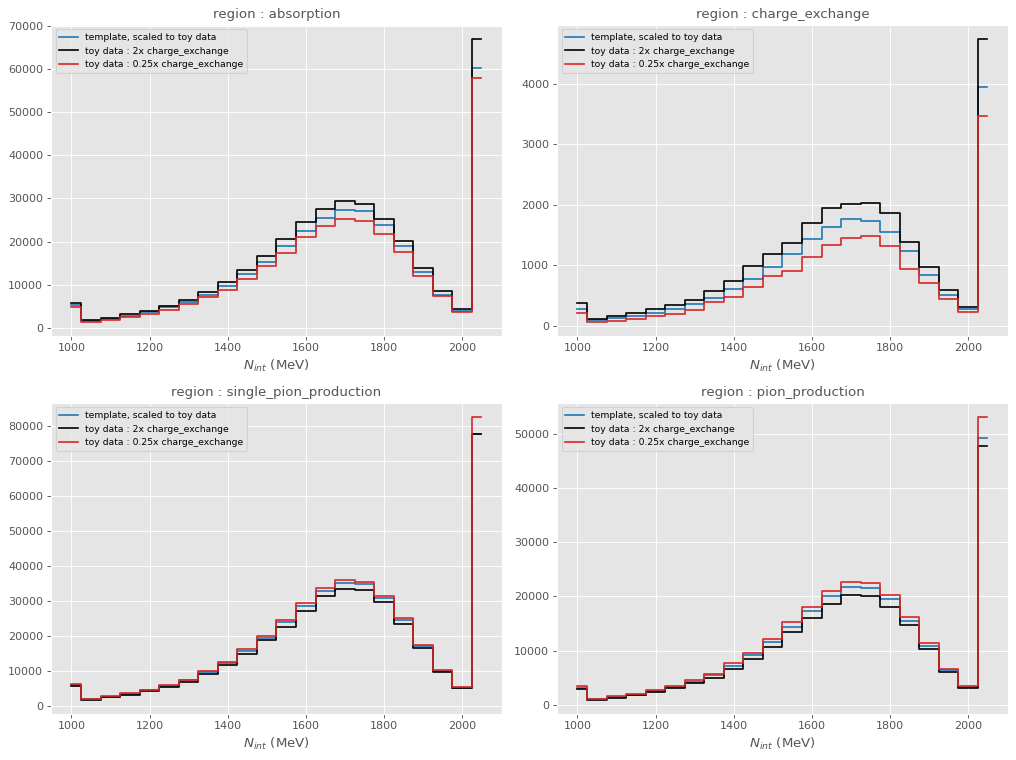

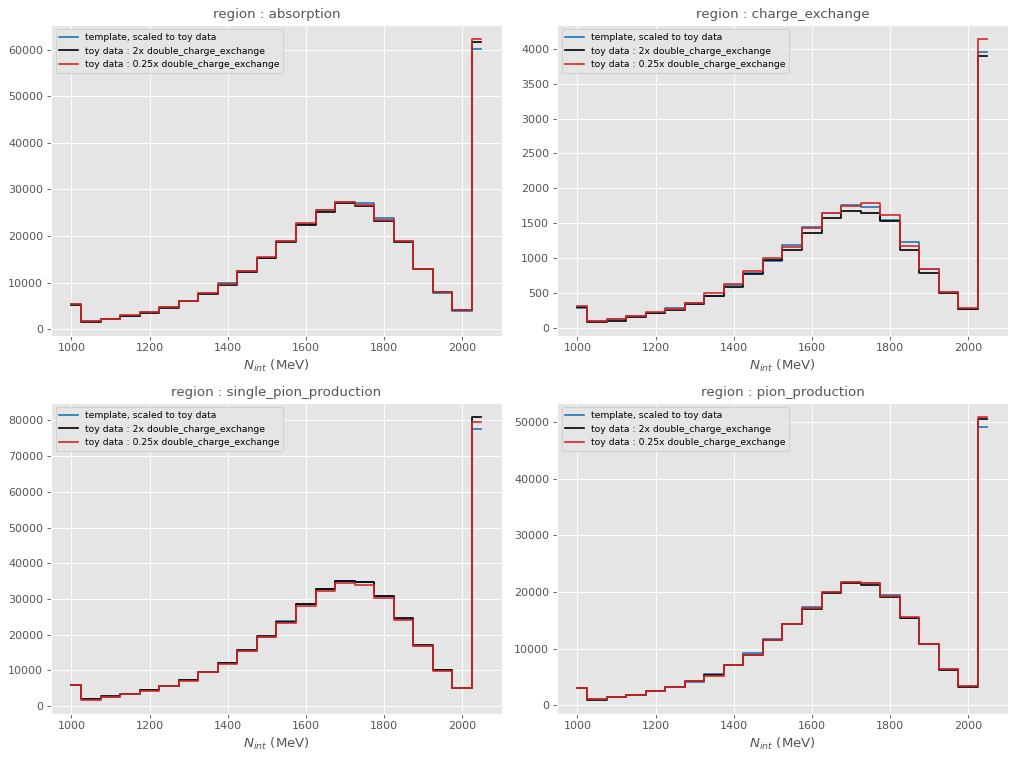

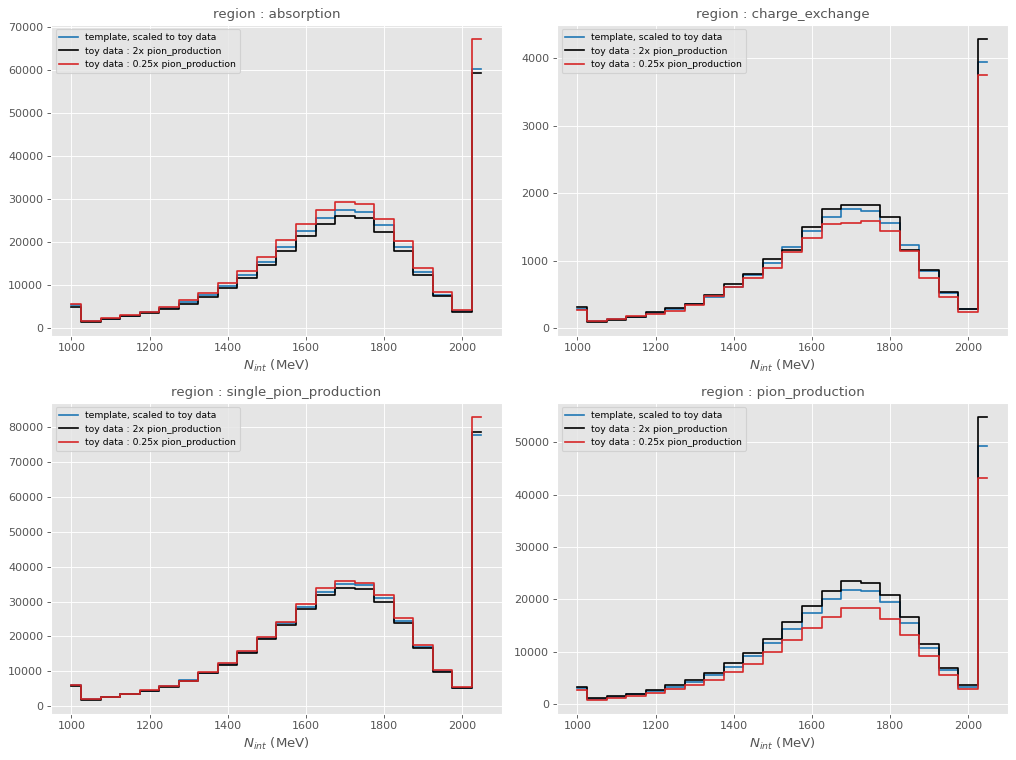

In [7]:
def CompareShapes(events : int, toy_config : dict, mean_track_score_bins : np.array = None, book : Plots.PlotBook = Plots.PlotBook.null):
    scale = events / len(toy_template.df)
    scales = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}

    n_int_temp = {r : toy_template.NInteract(energy_slice, toy_template.reco_regions[r]) for r in toy_template.reco_region_labels}

    n_channels = len(toy_template.reco_region_labels) + int(mean_track_score_bins is not None)

    tags = cross_section.Tags.ExclusiveProcessTags(toy_template.truth_regions)

    colors = ["k", "C6"]

    for p in scales:
        scales_low = dict(scales)
        scales_high = dict(scales)

        scales_low[p] = 0.25
        scales_high[p] = 2
        toy_config["events"] = events
        toys = {k : cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = s, **toy_config)))) for k, s in zip([f"toy data : 2x {p}", f"toy data : 0.25x {p}"], [scales_high, scales_low])}
        clear_output()

        multiplot = Plots.MultiPlot(n_channels)
        for r in toy_template.reco_region_labels:
            next(multiplot)
            Plots.Plot(energy_overflow, scale * n_int_temp[r], newFigure = False, style = "step", title = f"region : {r}", label = "template, scaled to toy data", xlabel = "$N_{int}$ (MeV)")
            for i, (k, v) in enumerate(toys.items()):
                n_int = v.NInteract(energy_slice, v.reco_regions[r])
                Plots.Plot(energy_overflow, n_int, newFigure = False, style = "step", label = k, color = colors[i])
        
        if mean_track_score_bins is not None:
            next(multiplot)
            Plots.PlotTagged(toy_template.df.mean_track_score.values, tags = tags, bins = mean_track_score_bins, newFigure = False, x_label = "mean track score", data_weights = scale * np.ones(len(toy_template.df)))
            for i, (k, v) in enumerate(toys.items()):
                mean_track_score = np.histogram(v.df.mean_track_score, bins = mean_track_score_bins)[0]
                Plots.Plot(cross_section.bin_centers(mean_track_score_bins), mean_track_score, newFigure = False, style = "step", label = k, color = colors[i])

        book.Save()

with Plots.PlotBook("shape_comparison.pdf", False) as book:
    CompareShapes(1E6, toy_data_config, None, book)

## Fit for different rates

In [13]:
def NormalisationTest(directory : str, data_config, model, toy_template, mean_track_score_bins):
    folder = {
        'absorption': "abs",
        'quasielastic': "quasi",
        'charge_exchange': "cex",
        'double_charge_exchange': "dcex",
        'pion_production': "pip"
    }

    for target in folder:
        print(target)

        results = {}
        true_counts = {}
        expected_mus = {}
        scales = {
            'absorption': 1,
            'quasielastic': 1,
            'charge_exchange': 1,
            'double_charge_exchange': 1,
            'pion_production': 1
            }
        for i in [0.25, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2]:
            scales[target] = i
            config = CreateConfig(scale_factors = scales, **data_config)
            print(config)
            results[i], true_counts[i], expected_mus[i] = ModifiedConfigTest(config, energy_slice, model, toy_template, None, mean_track_score_bins)
            clear_output()
            print(target)
        
        cross_section.SaveObject(f"{directory}fit_results_{folder[target]}.dill", {"results" : results, "true_counts" : true_counts, "expected_mus" : expected_mus}) # keep results for future reference
        with Plots.PlotBook(f"{directory}fit_results_{folder[target]}.pdf", True) as pdf:
            PlotCrossCheckResults(f"{target} normalisation", model, toy_template, results, true_counts, pdf)
        Plots.plt.close("all")
    return

NormalisationTest(
    directory = "test/region_fit_cross_checks_2GeV/normalisation_test/",
    data_config = {"PDSP" : 2, "p_init" : 2000, "seed" : 1, "events" : 1E6},
    model = model,
    toy_template = toy_template,
    mean_track_score_bins = None)

pion_production

pdf test/region_fit_cross_checks_2GeV/normalisation_test/fit_results_pip.pdf has been opened
pdf test/region_fit_cross_checks_2GeV/normalisation_test/fit_results_pip.pdf has been closed


In [7]:
directory = "test/region_fit_cross_checks_1GeV/normalisation_test_track_score/"
results_files = [i for i in cross_section.os.listdir(directory) if "dill" in i]

target_map = {
    "_abs" : 'absorption',
    "_quasi" : 'quasielastic',
    "_cex" : 'charge_exchange',
    "_dcex" : 'double_charge_exchange',
    "_pip" : 'pion_production'
}

for f in results_files:
    fit_result = cross_section.LoadObject(directory+f)
    target = [target_map[k] for k in target_map if k in f][0]
    with Plots.PlotBook(directory+f.split(".")[0]+".pdf", True) as pdf:
        PlotCrossCheckResults(f"{target} normalisation", model, toy_template, fit_result["results"], fit_result["true_counts"], pdf)
    Plots.plt.close("all")

pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_quasi.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_quasi.pdf has been closed
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_abs.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_abs.pdf has been closed
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_pip.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_pip.pdf has been closed
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_dcex.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_dcex.pdf has been closed
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_cex.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/normalisati

In [14]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 1,
    'double_charge_exchange': 1,
    'pion_production': 1
    }
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales, PDSP = 1, p_init = 1000, events = 1E6, seed = 1)))))
obs = cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, mean_track_score_bins, model, False)
fit_result = cross_section.RegionFit.Fit(obs, model, None, None, False)

postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = fit_result)


Simulating |████████████████████████████████████████| 10/10 [100%] in 32.5s (0.31/s) 


'BeamSelectionEfficiency' executed in 0.0537s

'GenerateRecoRegions' executed in 1.6038s

'MeanTrackScore' executed in 4.0452s

'main' executed in 41.3270s

init_params=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

pdf test/region_fit_cross_checks_1GeV/toy_obs_nominal.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/toy_obs_nominal.pdf has been closed


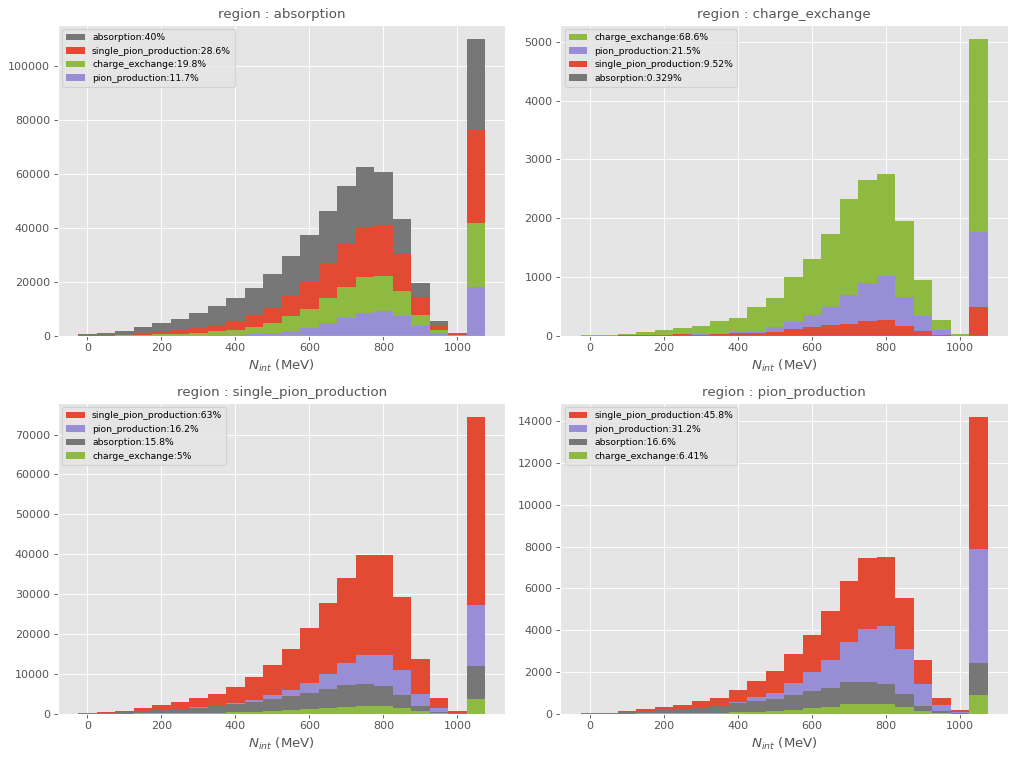

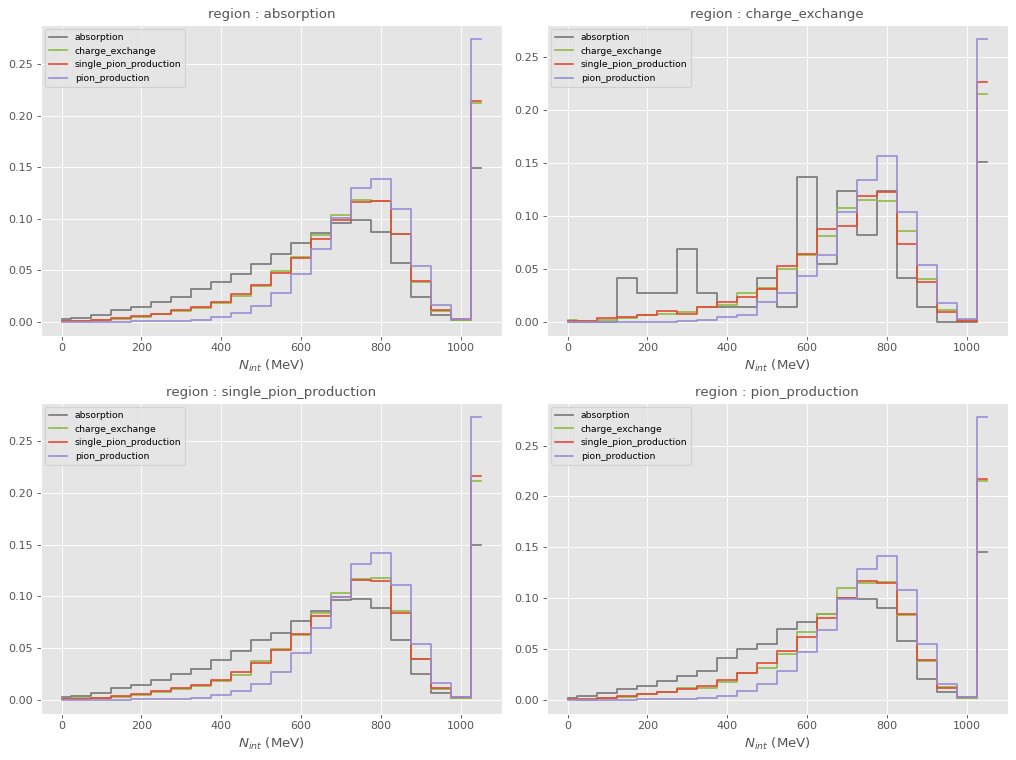

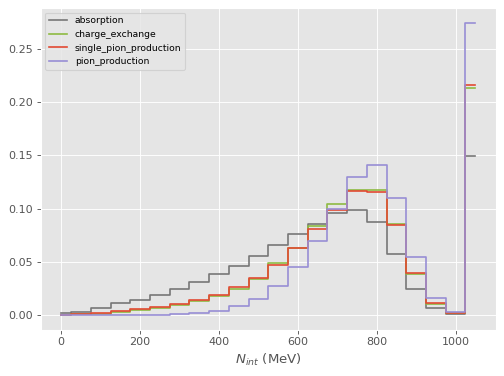

In [15]:
tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.exclusive_process)

with Plots.PlotBook("test/region_fit_cross_checks_1GeV/toy_obs_nominal.pdf", True) as pdf:
    for i, c in Plots.IterMultiPlot(toy_alt_pdf.regions):
        hists = {s : toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s], toy_alt_pdf.regions[c]) for s in toy_alt_pdf.exclusive_process}

        sorted_proc = [list(toy_alt_pdf.exclusive_process.keys())[j] for j in np.argsort([sum(h) for h in hists.values()])]

        total = np.zeros_like(energy_overflow)
        stacked_hists = {}
        for s in sorted_proc:
            total = total + hists[s]
            stacked_hists[s] = total

        for s in reversed(stacked_hists):
            purity = sum(toy_alt_pdf.exclusive_process[s] & toy_alt_pdf.regions[c]) / sum(toy_alt_pdf.regions[c])
            Plots.Plot(energy_overflow, stacked_hists[s], newFigure = False, label = s + f":{100*purity:.3g}%", color = tags[s].colour, style = "bar", xlabel = "$N_{int}$ (MeV)", title = f"region : {c}")
    pdf.Save()

    for i, c in Plots.IterMultiPlot(toy_alt_pdf.regions):
        hists = {s : toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s], toy_alt_pdf.regions[c]) for s in toy_alt_pdf.exclusive_process}
        for s in hists:
            Plots.Plot(energy_overflow, hists[s] / sum(hists[s]), newFigure = False, label = s, color = tags[s].colour, style = "step", xlabel = "$N_{int}$ (MeV)", title = f"region : {c}")
    pdf.Save()


    plt.figure()
    for s in toy_alt_pdf.exclusive_process:
        hists = toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s])
        Plots.Plot(energy_overflow, hists / sum(hists), newFigure = False, label = s, color = tags[s].colour, style = "step", xlabel = "$N_{int}$ (MeV)")
    pdf.Save()

# modified PDF shapes

## parameterisation

In [33]:
class lognormal_gaussian_exp(cross_section.Fitting.FitFunction):
    n_params = 8

    def __new__(cls, x, p0, p1, p2, p3, p4, p5, p6, p7) -> np.array:
        return cls.func(x, p0, p1, p2, p3, p4, p5, p6, p7)

    def func(x, p0, p1, p2, p3, p4, p5, p6, p7):
        lognormal_component = lognorm.pdf(x, s = p2, scale = p1)
        gaussian_component = norm.pdf(x, loc = p4, scale = p5)
        exponential_component = np.exp(-p7 * x)
        return p0 * lognormal_component + p3 * gaussian_component + p6 * exponential_component # Adjust weights as needed

    def bounds(x, y):
        lims = np.array([
            (0, 1),
            (min(x), max(x)),
            (0.001, np.inf),

            (0, 1),
            (min(x), max(x)),
            (0.001, np.inf),

            (-np.inf, np.inf),
            (-np.inf, np.inf),

        ])
        return (lims[:, 0], lims[:, 1])    


In [37]:
def FitSimulationCurve(sampling_factor : int, process : str, function : cross_section.Fitting.FitFunction):
    x = xs_sim.KE[::sampling_factor]/1000
    y = getattr(xs_sim, process)[::sampling_factor]/1000

    plt.figure()
    results = cross_section.Fitting.Fit(x, y, None, function, method = "dogbox", plot = True, xlabel = "$KE$(GeV)", ylabel = "$\sigma$ (b)", title = process)
    return results

xs_sim = cross_section.GeantCrossSections(energy_range = [0, max(energy_range)])

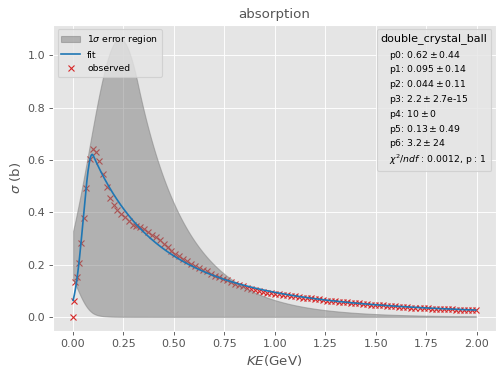

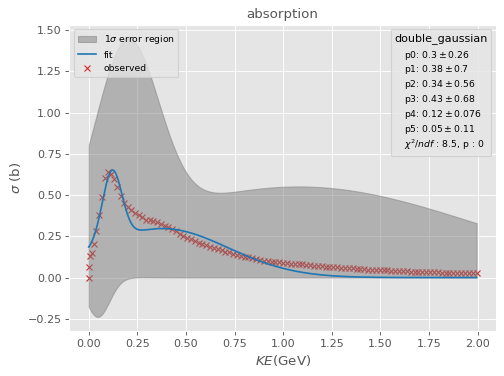

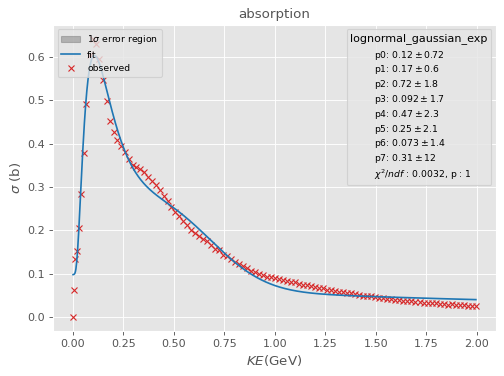

In [38]:
sampling_factor = 20
book = Plots.PlotBook("absorption_fit_attempts.pdf", False)
for f in [cross_section.Fitting.double_crystal_ball, cross_section.Fitting.double_gaussian, lognormal_gaussian_exp]:
    FitSimulationCurve(sampling_factor, "absorption", f)
    book.Save()
book.close()

absorption

quasielastic

charge_exchange

double_charge_exchange

pion_production

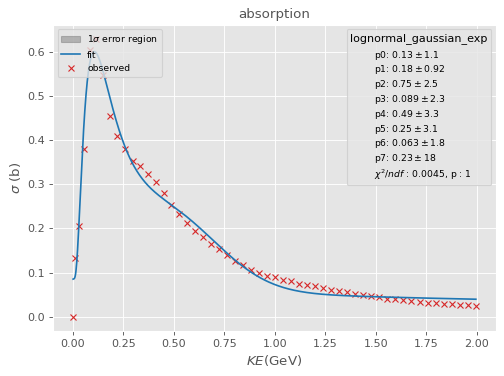

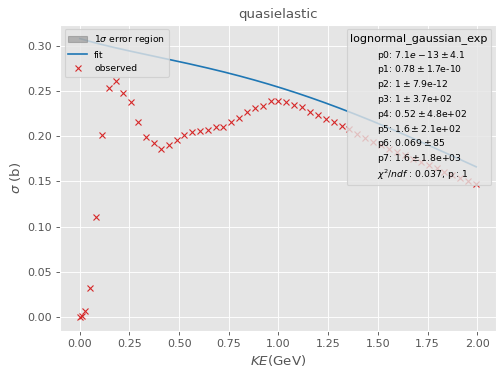

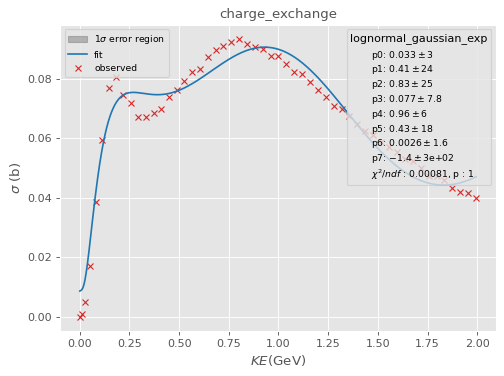

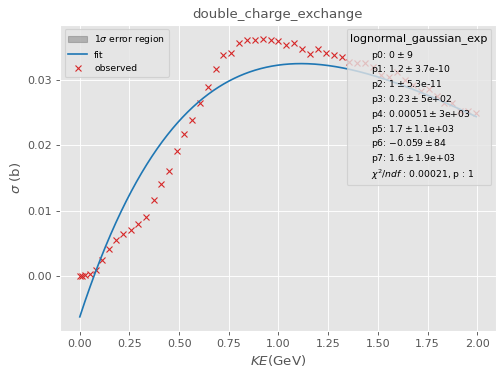

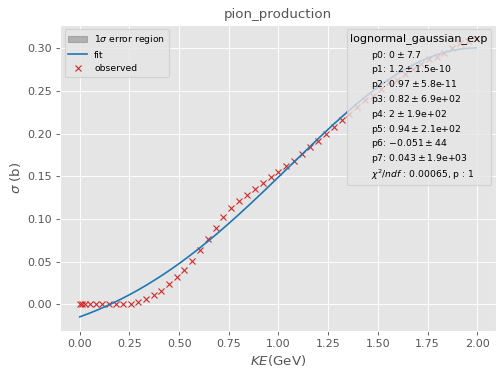

In [40]:
with Plots.PlotBook("xs_curve_fits.pdf", False) as book:
    xs_fit_results = {}
    for i in xs_sim.exclusive_processes:
        print(i)
        xs_fit_results[i] = FitSimulationCurve(40, i, lognormal_gaussian_exp)
        book.Save()

[
    array([ 0.05029494,  0.17984281,  0.74721799,  0.08890995, 48.71769941,
        0.2278285 ,  0.07596682,  0.23346731]),
    array([ 0.09115958,  0.17984281,  0.74721799,  0.08890995, 36.6600688 ,
        0.25314278,  0.0712189 ,  0.26265073]),
    array([0.12573735, 0.17984281, 0.74721799, 0.08890995, 0.48717699,
       0.25314278, 0.06330569, 0.23346731]),
    array([ 0.17288886,  0.17984281,  0.74721799,  0.08890995, 12.5448076 ,
        0.30377134,  0.06172304,  0.32101755]),
    array([0.2137535 , 0.17984281, 0.74721799, 0.08890995, 0.48717699,
       0.32908561, 0.05697512, 0.35020097])
]

[
    array([3.19410166e-13, 6.63816651e-01, 8.34748623e-01, 1.08000000e+00,
       6.00691035e-01, 1.58128045e+00, 6.92776760e-02, 2.47280047e+00]),
    array([5.58967791e-13, 7.32150718e-01, 9.39092201e-01, 1.06000000e+00,
       5.81103284e-01, 1.58128045e+00, 6.92776760e-02, 2.06066706e+00]),
    array([7.09800370e-13, 7.80960766e-01, 1.04343578e+00, 1.00000000e+00,
       5.22340031e-01, 1.58128045e+00, 6.92776760e-02, 1.64853365e+00]),
    array([1.03808304e-12, 8.68818852e-01, 1.14777936e+00, 1.02000000e+00,
       5.41927782e-01, 1.58128045e+00, 6.92776760e-02, 1.23640024e+00]),
    array([1.27764067e-12, 9.37152919e-01, 1.25212293e+00, 1.00000000e+00,
       5.22340031e-01, 1.58128045e+00, 6.92776760e-02, 8.24266824e-01])
]

[
    array([ 0.02307912,  0.36613795,  0.83420336,  0.08480037,  0.959778  ,
        0.41130722,  0.00257066, -1.3978439 ]),
    array([ 0.02967316,  0.38647895,  0.83420336,  0.08056035,  0.959778  ,
        0.42754303,  0.00257066, -1.3978439 ]),
    array([ 0.03297017,  0.40681995,  0.83420336,  0.07709125,  0.959778  ,
        0.43295497,  0.00257066, -1.3978439 ]),
    array([ 0.04286123,  0.42716095,  0.83420336,  0.07208031,  0.959778  ,
        0.46001465,  0.00257066, -1.3978439 ]),
    array([ 0.04945526,  0.44750194,  0.83420336,  0.0678403 ,  0.959778  ,
        0.47625047,  0.00257066, -1.3978439 ])
]

[
    array([ 0.00000000e+00,  1.29704968e+00,  9.46015657e-01,  1.86559162e-01,
        5.14727231e-04,  1.81523280e+00, -5.85506239e-02,  1.52031101e+00]),
    array([ 0.00000000e+00,  1.23809288e+00,  9.58463231e-01,  2.04932413e-01,
        5.14727231e-04,  1.77201297e+00, -5.85506239e-02,  1.54031510e+00]),
    array([ 0.00000000e+00,  1.17913607e+00,  9.95805955e-01,  2.26132318e-01,
        5.14727231e-04,  1.72879314e+00, -5.85506239e-02,  1.60032738e+00]),
    array([ 0.00000000e+00,  1.12017927e+00,  9.83358380e-01,  2.41678915e-01,
        5.14727231e-04,  1.68557331e+00, -5.85506239e-02,  1.58032329e+00]),
    array([ 0.00000000e+00,  1.06122246e+00,  9.95805955e-01,  2.60052166e-01,
        5.14727231e-04,  1.64235348e+00, -5.85506239e-02,  1.60032738e+00])
]

[
    array([ 0.        ,  1.15280148,  0.97211151,  0.61212601,  2.01455712,
        0.9381916 , -0.00508764,  0.0864901 ]),
    array([ 0.        ,  1.15280148,  0.97211151,  0.63865147,  2.01206386,
        0.90300941, -0.00508764,  0.07567884]),
    array([ 0.        ,  1.15280148,  0.97211151,  0.81616801,  1.99461101,
        0.9381916 , -0.05087642,  0.04324505]),
    array([ 0.        ,  1.15280148,  0.97211151,  0.69170239,  2.00707733,
        0.83264504, -0.00508764,  0.05405631]),
    array([ 0.        ,  1.15280148,  0.97211151,  0.71822785,  2.00458406,
        0.79746286, -0.00508764,  0.04324505])
]

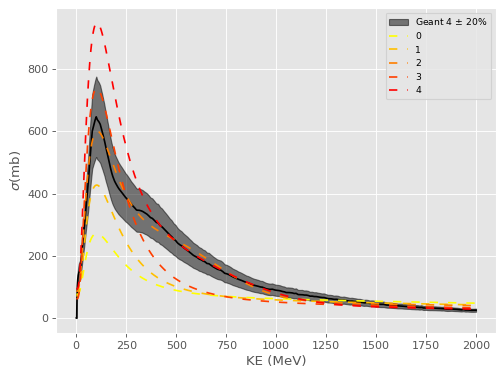

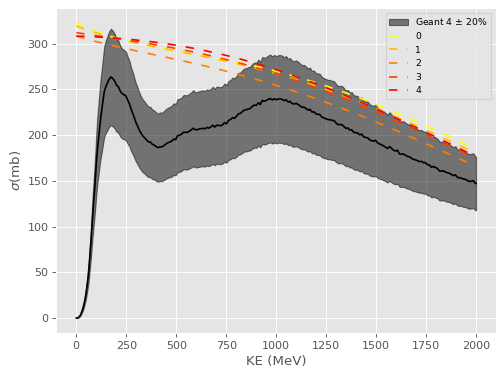

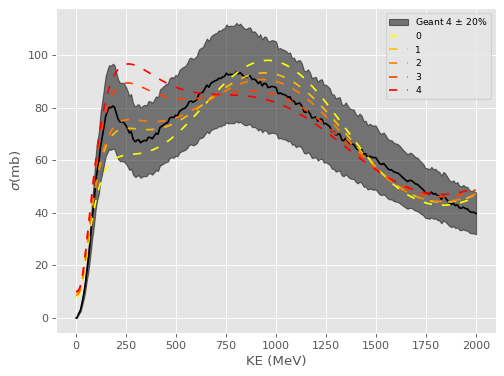

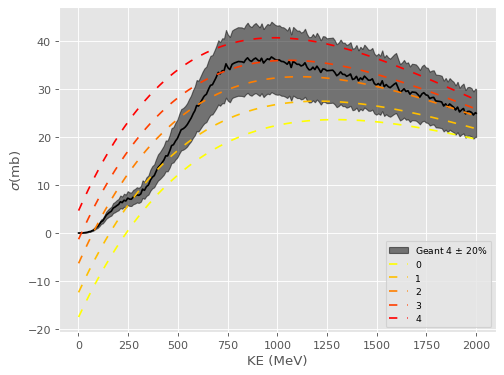

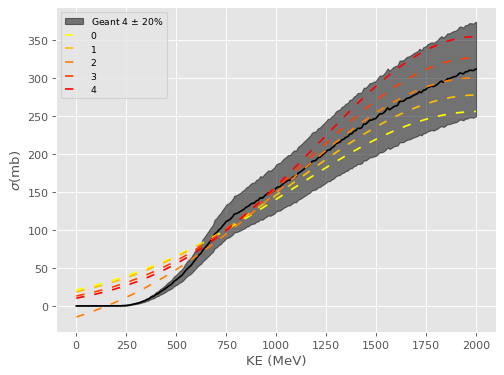

In [41]:
def CreateShapeParams(process : str, high, low):
    params = np.array(xs_fit_results[process][0])
    step = (high - low) / 100
    shape_params = []
    for i in [0, 25, 75, 100]:
        shape_params.append((low + (i *step)) * params)
    shape_params.insert(2, params)

    xs = getattr(xs_sim, process)

    Plots.Plot(xs_sim.KE, xs, color = "k", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
    Plots.plt.fill_between(xs_sim.KE, 0.8 * xs, 1.2 * xs, alpha = 0.5, color = "k", label = "Geant 4 $\pm$ 20%")

    c = Plots.plt.cm.autumn_r(np.linspace(0, 1, len(shape_params)))
    for i in range(len(shape_params)):
        Plots.Plot(xs_sim.KE, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *shape_params[i]), color = c[i], linestyle = (0, (5, 6)), newFigure = False, label = i)
    return shape_params


shape_param_factors = {
    "absorption" : [np.array([1.7, 1, 1, 1, 1, 1.3, 0.9, 1.5]), np.array([0.4, 1, 1, 1, 100, 0.9, 1.2, 1])],
    "quasielastic" : [np.array([1.8, 1.2, 1.2, 1, 1, 1, 1, 0.5]), np.array([0.45, 0.85, 0.8, 1.08, 1.15, 1, 1, 1.5])],
    "charge_exchange" : [np.array([1.5, 1.1, 1, 0.88, 1, 1.1, 1, 1]), np.array([0.7, 0.9, 1, 1.1, 1, 0.95, 1, 1])],
    "double_charge_exchange" : [np.array([0.7, 0.9, 1, 1.15, 1, 0.95, 1, 1]), np.array([1.5, 1.1, 0.95, 0.825, 1, 1.05, 1, 0.95])],
    "pion_production" : [np.array([0, 1, 1, 0.88, 1.005, 0.85, 0.1, 1]), np.array([0, 1, 1, 0.75, 1.01, 1, 0.1, 2])]
}

for k, v in shape_param_factors.items():
    CreateShapeParams(k, v[0], v[1])

## spline

In [15]:
from scipy.interpolate import CubicSpline

def CreateShapeParamsSpline(xs_sim, process, indices, shape_factors):    
    xs = getattr(xs_sim, process)
    Plots.Plot(xs_sim.KE, xs, color = "k", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
    Plots.plt.fill_between(xs_sim.KE, 0.8 * xs, 1.2 * xs, alpha = 0.5, color = "k", label = "Geant 4 $\pm$ 20%")

    x = xs_sim.KE
    x_sample = x[indices[process]]
    y_sample = xs[indices[process]]

    c = Plots.plt.cm.autumn_r(np.linspace(0, 1, 5))
    step = (shape_factors[process][1] - shape_factors[process][0]) / 4
    splines = []
    for i in range(5):
        spline = CubicSpline(x_sample, (shape_factors[process][0] + (i * step))* y_sample)
        splines.append(spline)
        Plots.Plot(xs_sim.KE, spline(xs_sim.KE), linestyle = (0, (5, 6)), color = c[i], label = i, newFigure = False)
    return splines

In [16]:
spline_point_index = {
    "absorption" : [5, 40, 65, 100, 180, 245, 300, 420, 750, 1120, -500, -1],
    "quasielastic" : [5, 100, 200, 270, 330, 520, 650, 860, 1120, -750, -250, -1],
    "charge_exchange" : [5, 100, 200, 270, 330, 650, 860, 1120, -750, -250, -1],
    "double_charge_exchange" : [5, 150, 270, 400, 800, 1120, -450, -1],
    "pion_production" : [5, 400, 600, 850, 1120, -450, -1],
}
# arranged low, high
spline_shape_param_factors = {
    "absorption" : [np.array([1.2, 1, 1, 1, 1.2, 1.1, 1, 0.85, 1, 1.2, 1, 0.8]), np.array([0.8, 1, 1, 1, 0.8, 0.9, 1, 1.15, 1, 0.8, 1, 1.2])],
    "quasielastic" : [np.array([0.8, 0.8, 0.8, 1.15, 1.1, 0.85, 0.8, 1, 1.2, 1.1, 0.9, 0.8]), np.array([1.2, 1.2, 0.8, 0.8, 0.9, 1.2, 1, 0.9, 0.8, 0.9, 1.1, 1.2])],
    "charge_exchange" : [np.array([1.2, 1.2, 1.2, 1.15, 1, 1, 1.2, 1.1, 1, 0.9, 0.8]), np.array([0.8, 0.8, 0.8, 0.85, 1, 1, 0.82, 0.82, 0.9, 1.1, 1.2])],
    "double_charge_exchange" : [np.array([1.2, 1.2, 1.2, 0.85, 1.1, 1.2, 1, 0.8]), np.array([0.8, 0.8, 0.8, 1.15, 0.85, 0.85, 1, 1.2])],
    "pion_production" : [np.array([0.8, 0.8, 1, 1.2, 1.1, 0.9, 0.8]), np.array([1.2, 1.2, 0.8, 0.8, 0.9, 1.1, 1.2])]
}


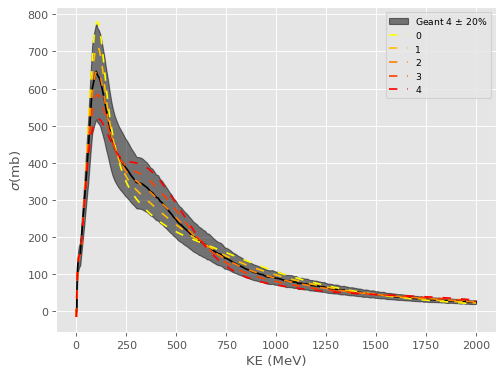

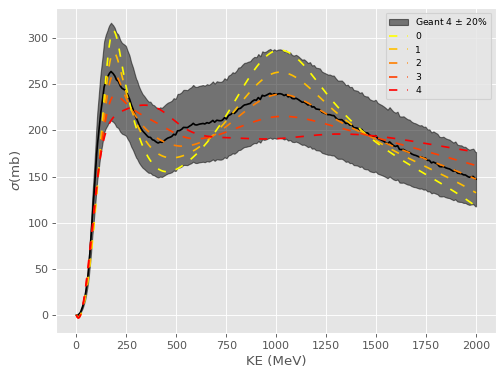

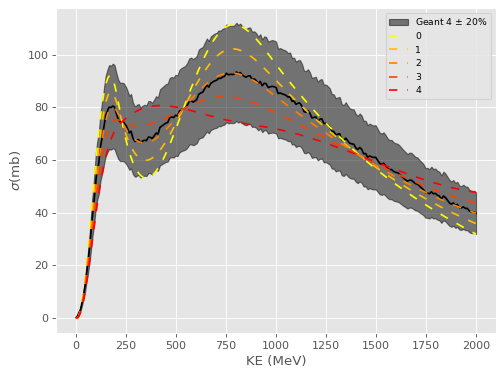

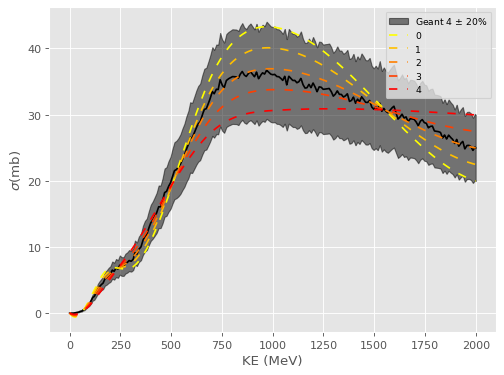

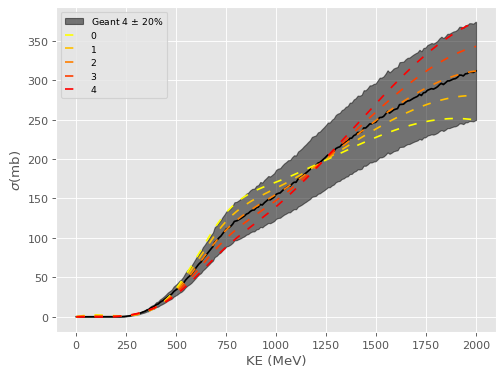

In [18]:
xs_sim = cross_section.GeantCrossSections(energy_range = [0, 2000])

for k in spline_shape_param_factors:
    CreateShapeParamsSpline(xs_sim, k, spline_point_index, spline_shape_param_factors)

## shape test

In [19]:
def PlotHistShapeTest(config : dict, shape_params : dict, type : str, events : int, book : Plots.PlotBook = Plots.PlotBook.null):
    if type == "function":
        config_high = CreateConfig(**config, events = events, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *shape_params[-1])))
        config_low = CreateConfig(**config, events = events, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *shape_params[0])))
    elif type == "spline":
        config_high = CreateConfig(**config, events = events, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, shape_params[1](xs_sim.KE)))
        config_low = CreateConfig(**config, events = events, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, shape_params[0](xs_sim.KE)))
    else:
        raise Exception("not a valid type")
    toys = {
    "nominal" : cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(**config, events = events))))),
    "high" : cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_high)))),
    "low" : cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_low))))
    }

    def ratio_err(a, b):
        return abs((a/b) * np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2))

    def RatioPlot(data):
        for _, i in Plots.IterMultiPlot(data):
            Plots.Plot(energy_overflow, data[i]["high"] / data[i]["nominal"], yerr = ratio_err(data[i]["high"], data[i]["nominal"]), color = colours["high"], label = "high", title = i, xlabel = "$N_{int}$ (MeV)", ylabel = "ratio", marker = "o", newFigure = False, linestyle = "")
            Plots.Plot(energy_overflow, data[i]["low"] / data[i]["nominal"], yerr = ratio_err(data[i]["low"], data[i]["nominal"]), color = colours["low"], label = "low", title = i, xlabel = "$N_{int}$ (MeV)", ylabel = "ratio", marker = "o", newFigure = False, linestyle = "")
            Plots.plt.axhline(1, color = "k")
            Plots.plt.ylim(0, 2)
        book.Save()
        return

    colours = {"nominal" : "k", "high" : "C6", "low" : "C0"}

    n_interact_process = {}
    for _, i in Plots.IterMultiPlot(toys["nominal"].exclusive_process):
        tmp = {}
        for k, v in toys.items():
            tmp[k] = v.NInteract(energy_slice, v.exclusive_process[i])
            Plots.Plot(energy_overflow, tmp[k] / sum(tmp[k]), yerr = np.sqrt(tmp[k]) / sum(tmp[k]), label = k, title = i, color = colours[k], xlabel = "$N_{int}$ (MeV)", ylabel = "fractional counts", style = "step", newFigure = False)
        n_interact_process[i] = tmp
    book.Save()

    RatioPlot(n_interact_process)

    n_interact_region = {}
    for _, i in Plots.IterMultiPlot(toys["nominal"].regions):
        tmp = {}
        for k, v in toys.items():
            tmp[k] = v.NInteract(energy_slice, v.regions[i])
            Plots.Plot(energy_overflow, tmp[k] / sum(tmp[k]), yerr = np.sqrt(tmp[k]) / sum(tmp[k]), label = k, color = colours[k], title = f"reco region : {i}", xlabel = "$N_{int}$ (MeV)", ylabel = "fractional counts", style = "step", newFigure = False)
        n_interact_region[i] = tmp
    book.Save()

    RatioPlot(n_interact_region)
    return

def CreateModPDFDict(KE : np.array, name : str, xs : np.array) -> dict[np.array]:
    return {
        "KE" : KE,
        name : xs
    }


In [23]:
def ShapeTest(directory, data_config, method, shape_param_factors, spline_shape_param_factors, model, toy_template, mean_track_score_bins):
    folder = {
        'absorption': "abs",
        'quasielastic': "quasi",
        'charge_exchange': "cex",
        'double_charge_exchange': "dcex",
        'pion_production': "pip"
    }
    for target in folder:
        results = {}
        true_counts = {}
        expected_mus = {}

        with Plots.PlotBook(f"{directory}fit_results_{folder[target]}.pdf", True) as pdf:
            if method == "function":
                shape_params = CreateShapeParams(target, shape_param_factors[target][0], shape_param_factors[target][1])
            elif method == "spline":
                shape_params = CreateShapeParamsSpline(xs_sim, target, spline_point_index, spline_shape_param_factors)
            else:
                raise Exception(f"{method} not a valid type")

            pdf.Save()
            PlotHistShapeTest(toy_data_config, shape_params, "spline", config["event"], pdf)
            for i, p in enumerate(shape_params):
                if method == "function":
                    config = CreateConfig(**data_config, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *p)))
                elif method == "spline":
                    config = CreateConfig(**data_config, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, p(xs_sim.KE)))
                else:
                    raise Exception(f"{method} not a valid type")
                results[i], true_counts[i], expected_mus[i] = ModifiedConfigTest(config, energy_slice, model, toy_template, None, mean_track_score_bins)
                clear_output()
                print(target)

            cross_section.SaveObject(f"{directory}fit_results_{folder[target]}.dill", {"results" : results, "true_counts" : true_counts, "expected_mus" : expected_mus}) # keep results for future reference
            PlotCrossCheckResults(f"{target} shape", model, toy_template, results, true_counts, pdf)
        Plots.plt.close("all")
    return

ShapeTest(
    directory = "test/region_fit_cross_checks_2GeV/shape_test/",
    data_config = {"PDSP" : 2, "p_init" : 2000, "seed" : 1, "events" : 1E6},
    method = "function",
    shape_param_factors = shape_param_factors,
    spline_shape_param_factors = spline_shape_param_factors,
    model = model,
    toy_template = toy_template,
    mean_track_score_bins = mean_track_score_bins
    )

pion_production

pdf test/region_fit_cross_checks_2GeV/shape_test/fit_results_pip.pdf has been closed


In [20]:
folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}
directory = f"test/region_fit_tests_shape_track_score/"

# for k, v in folder.items():
#     with Plots.PlotBook(f"{dire}fit_results_{folder[k]}.pdf", False) as pdf:
#         results = cross_section.LoadObject(f"{dire}fit_results_{v}.dill")
#         PlotFitResults(f"{k} shape", model, toy_template, results["results"], results["true_counts"], pdf)


# initial conditions

In [27]:
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1, events = 1E6)))))

Simulating |████████████████████████████████████████| 10/10 [100%] in 41.3s (0.24/s) 


'BeamSelectionEfficiency' executed in 0.0588s

'GenerateRecoRegions' executed in 1.7429s

'MeanTrackScore' executed in 4.6643s

'main' executed in 51.0547s

In [34]:
def PullStudy(toy_template : cross_section.Toy, model : cross_section.pyhf.Model, data_config : dict, n : int) -> dict:
    out = {"expected" : None, "scale" : pd.Series(len(toy_template.df) / data_config["events"]), "bestfit" : None, "uncertainty" : None}

    template_fractions = {s : (sum(toy_template.truth_regions[s]) / len(toy_template.df)) for s in toy_template.truth_region_labels}

    expected = []
    bestfit = []
    uncertainty = []

    for i in range(n):
        print(i)
        toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(data_config))))

        expected.append({s : (sum(toy_alt_pdf.exclusive_process[s]) / len(toy_alt_pdf.exclusive_process[s])) / template_fractions[s] for s in toy_alt_pdf.exclusive_process})

        init_params = list(np.random.uniform(0, 101, 4))

        result = cross_section.RegionFit.Fit(cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, None, model), model, init_params, [(0, np.inf)]*4, False)

        bestfit.append({list(toy_alt_pdf.exclusive_process.keys())[j] : result.bestfit[j] for j in range(len(toy_template.truth_region_labels))})
        uncertainty.append({list(toy_alt_pdf.exclusive_process.keys())[j] : result.uncertainty[j] for j in range(len(toy_template.truth_region_labels))})
        clear_output()

    out["expected"] = pd.DataFrame(expected)
    out["bestfit"] = pd.DataFrame(bestfit)
    out["uncertainty"] = pd.DataFrame(uncertainty)
    return out

config = CreateConfig(seed = None, events = 1E6, verbose = False)
out = PullStudy(toy_template, model, config, 100)

In [35]:
DictToHDF5(out, "test/1GeV_pull_study_var.hdf5")

pdf pulls_1E6.pdf has been opened
pdf pulls_1E6.pdf has been closed


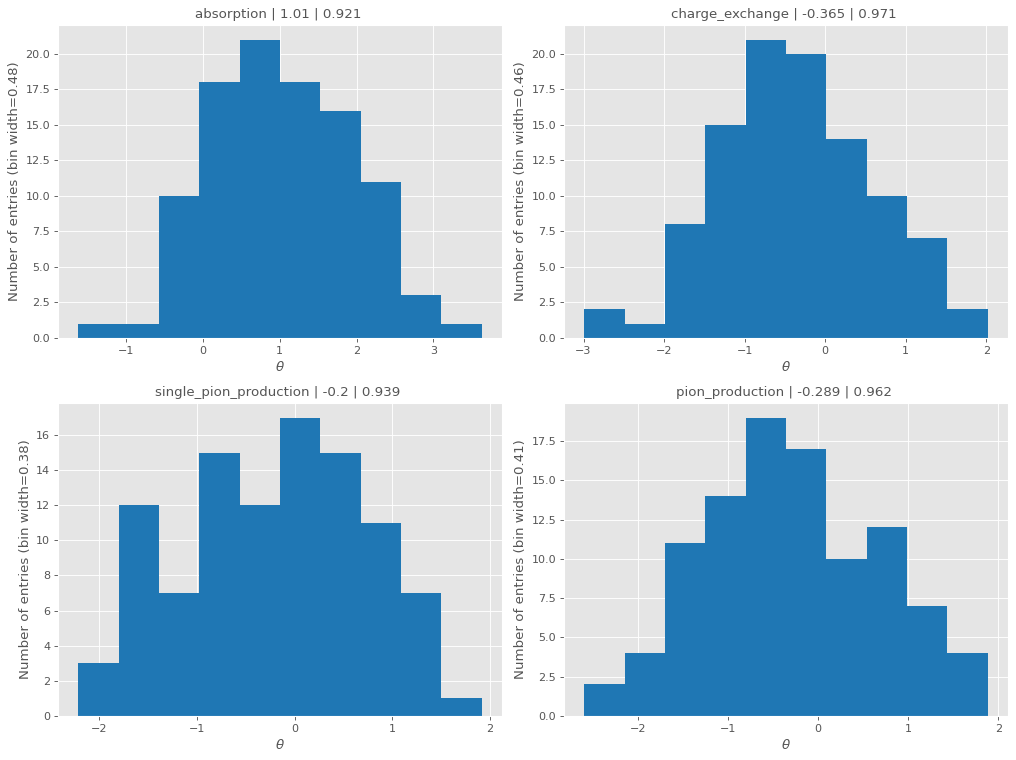

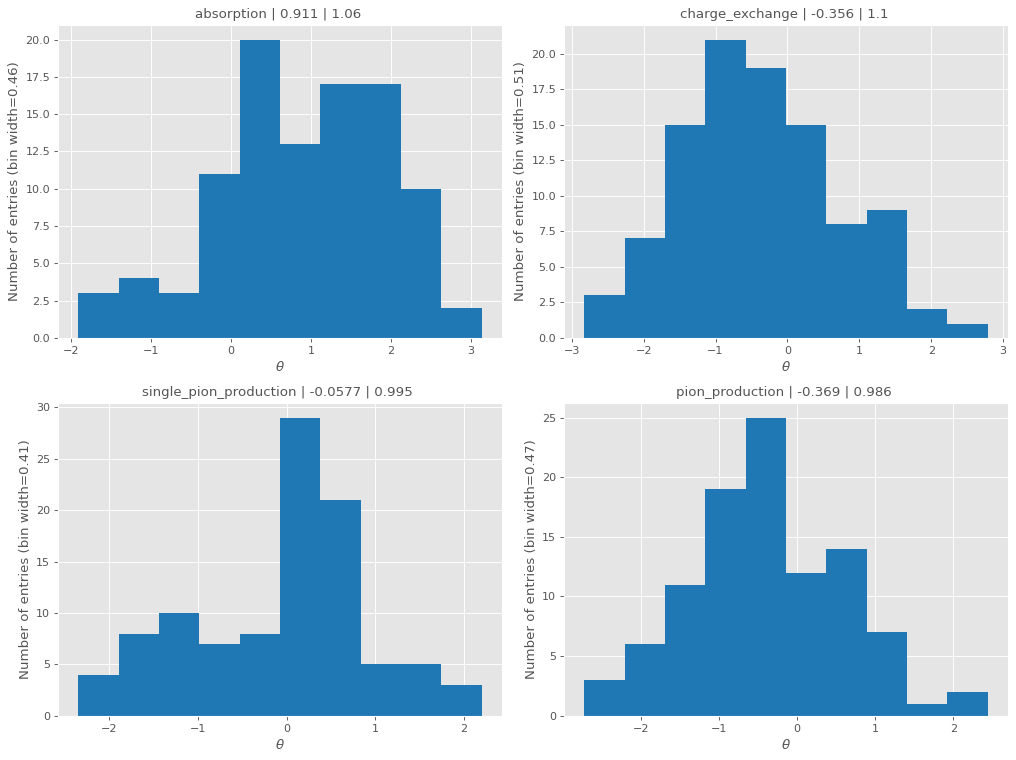

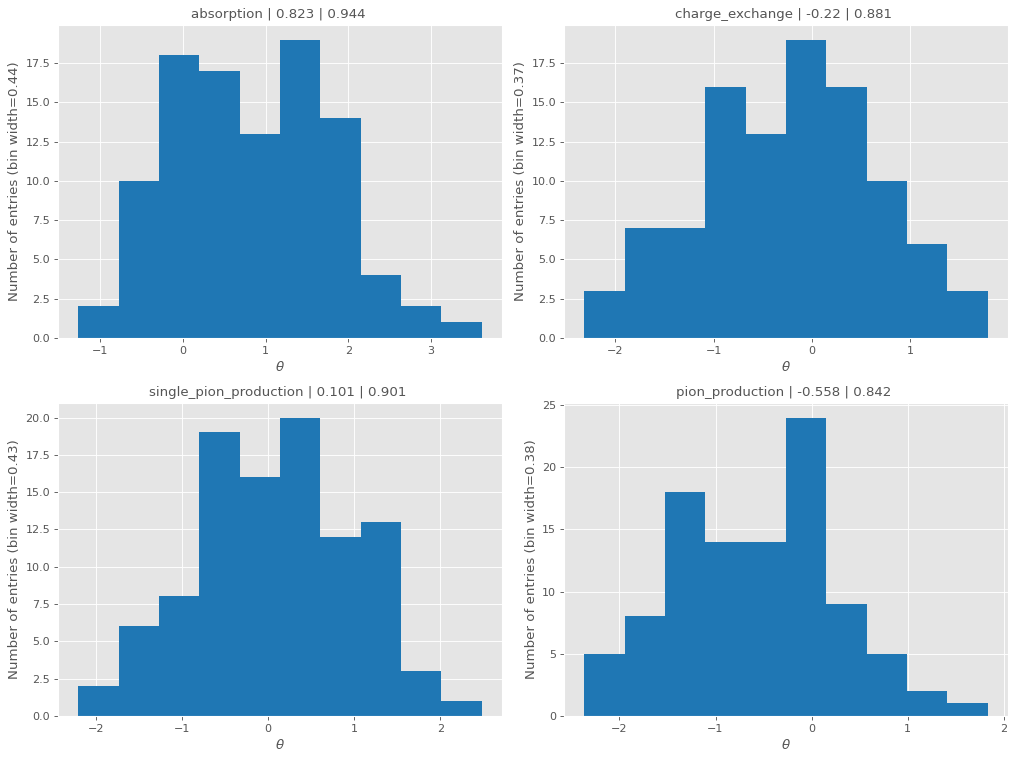

In [196]:
with Plots.PlotBook("pulls_1E6.pdf", True) as book:
    out = ReadHDF5("test/1GeV_pull_study.hdf5")

    pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

    xlabel = "$\\theta$"

    for _, k in Plots.IterMultiPlot(pulls.columns):
        Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", xlabel = xlabel, newFigure = False)
    book.Save()

    out = ReadHDF5("test/1GeV_pull_study_2.hdf5")

    pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

    for _, k in Plots.IterMultiPlot(pulls.columns):
        Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", xlabel = xlabel, newFigure = False)
    book.Save()

    out = ReadHDF5("test/1GeV_pull_study_var.hdf5")

    pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

    for _, k in Plots.IterMultiPlot(pulls.columns):
        Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", xlabel = xlabel, newFigure = False)
    book.Save()

# covariance matrix

In [662]:
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1)))))
result = cross_section.RegionFit.Fit(cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, None, model), model)

Simulating |████████████████████████████████████████| 1/1 [100%] in 2.2s (0.45/s) 


'BeamSelectionEfficiency' executed in 0.0067s

'GenerateRecoRegions' executed in 0.0731s

'MeanTrackScore' executed in 0.4466s

'main' executed in 2.9503s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9611787.72236069])
init_params=None
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.00513612, 0.00528889, 0.00532074, 0.00412713])
uncertainty=array([0.00013014, 0.00023433, 0.00013323, 0.00034891])
result=FitResults(bestfit=array([0.00513612, 0.00528889, 0.00532074, 0.00412713]), uncertainty=array([0.00013014, 0.00023433, 0.00013323, 0.00034891]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.68658324 -0.57921909  0.40724318]
 [-0.68658324  1.          0.4638389  -0.59824561]
 [-0.57921909  0.4638389   1.         -0.84800042]
 [ 0.40724318 -0.59824561 -0.84800042  1.        ]], best_twice_nll=693.9193682284744, goodness_of_fit=-1, minos_uncertainty={})


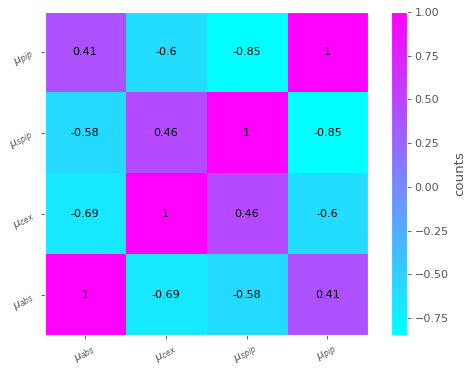

In [711]:
def PlotCorrelationMatrix(counts : np.array = None, x_labels = None, y_labels = None, title : str = None, newFigure : bool = True, cmap : str = "cool"):
    """ Plots Correlation matrix of two sets of regions.

    Args:
        true_regions (dict): true regions
        reco_regions (dict): reco regions
        title (str, optional): title. Defaults to None.
    """
    if newFigure: Plots.plt.figure()
    Plots.plt.imshow(counts, cmap = cmap, origin = "lower")
    Plots.plt.colorbar(label = "counts")

    if x_labels is None:
        x_labels = range(counts.shape[0])
    if y_labels is None:
        y_labels = range(counts.shape[1])

    Plots.plt.gca().set_xticks(np.arange(len(x_labels)), labels=x_labels)
    Plots.plt.gca().set_yticks(np.arange(len(y_labels)), labels=y_labels)

    Plots.plt.xticks(rotation = 30)
    Plots.plt.yticks(rotation = 30)

    if title is not None:
        Plots.plt.title(title)

    for (i, j), z in np.ndenumerate(counts):
        Plots.plt.gca().text(j, i, f"{z:.2g}", ha='center', va='center')
    Plots.plt.grid(False)
    Plots.plt.tight_layout()

PlotCorrelationMatrix(result.corr_mat, x_labels = ["$\mu_{abs}$", "$\mu_{cex}$", "$\mu_{spip}$", "$\mu_{pip}$"], y_labels = ["$\mu_{abs}$", "$\mu_{cex}$", "$\mu_{spip}$", "$\mu_{pip}$"])

# Background subtraction performance

In [19]:
def BackgroundPerformanceCheck(directory : str, signal_process : str, model : cross_section.pyhf.Model):
    results_files = [i for i in cross_section.os.listdir(directory) if "dill" in i]

    target_map = {
        "_abs" : 'absorption',
        "_quasi" : 'quasielastic',
        "_cex" : 'charge_exchange',
        "_dcex" : 'double_charge_exchange',
        "_pip" : 'pion_production'
    }

    Plots.plt.figure()
    for f in results_files:
        fit_results = cross_section.LoadObject(directory + f)
        target = [target_map[k] for k in target_map if k in f][0]

        _, (fractional_error, fractional_error_err) = BSFractionalError(model, toy_template, fit_results, signal_process)

        x = range(len(list(fit_results["results"].keys())))
        Plots.Plot(x, fractional_error, yerr = fractional_error_err, marker = "o", xlabel = "normalisation", ylabel = "fractional error in total background counts", label = target, newFigure = False)
        Plots.plt.xticks(ticks = x, labels = fit_results["results"].keys())
    return


def BackgroundSubtractionPerformanceCheck(directory : str, signal_process : str, model : cross_section.pyhf.Model):
    results_files = [i for i in cross_section.os.listdir(directory) if "dill" in i]

    target_map = {
        "_abs" : 'absorption',
        "_quasi" : 'quasielastic',
        "_cex" : 'charge_exchange',
        "_dcex" : 'double_charge_exchange',
        "_pip" : 'pion_production'
    }

    Plots.plt.figure()
    for f in results_files:
        fit_results = cross_section.LoadObject(directory + f)
        target = [target_map[k] for k in target_map if k in f][0]

        (fractional_error, fractional_error_err), _ = BSFractionalError(model, toy_template, fit_results, signal_process)

        x = range(len(list(fit_results["results"].keys())))
        Plots.Plot(x, fractional_error, yerr = fractional_error_err, marker = "o", xlabel = "normalisation", ylabel = "fractional error in total background subtracted counts", label = target, newFigure = False)
        Plots.plt.xticks(ticks = x, labels = fit_results["results"].keys())
    return

In [62]:
model_track_score = cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, mean_track_score_bins, False, None, False)
model_normal = cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, None, False, None, False)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


pdf test/region_fit_cross_checks_1GeV/background_sub_fractional_err.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/background_sub_fractional_err.pdf has been closed


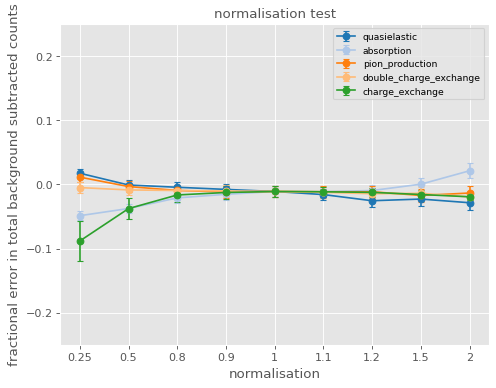

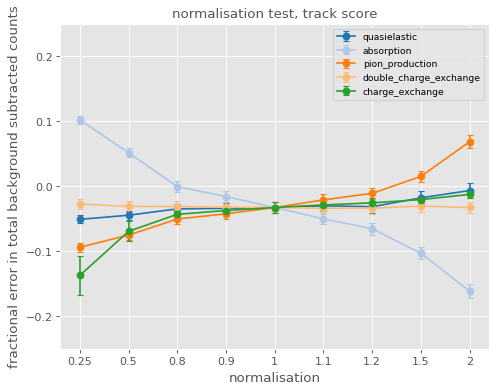

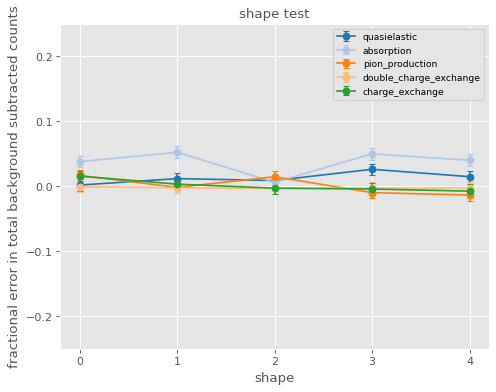

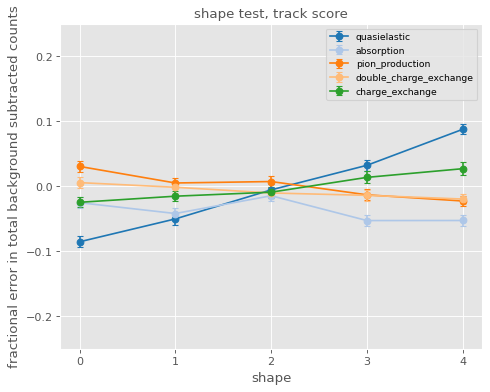

In [65]:
with Plots.PlotBook("test/region_fit_cross_checks_1GeV/background_sub_fractional_err.pdf", True) as book:
    BackgroundSubtractionPerformanceCheck("test/region_fit_cross_checks_1GeV/normalisation_test/", "charge_exchange", model_normal)
    Plots.plt.title("normalisation test")
    Plots.plt.ylim(-0.25, 0.25)
    book.Save()

    BackgroundSubtractionPerformanceCheck("test/region_fit_cross_checks_1GeV/normalisation_test_track_score/", "charge_exchange", model_track_score)
    Plots.plt.title("normalisation test, track score")
    Plots.plt.ylim(-0.25, 0.25)
    book.Save()

    BackgroundSubtractionPerformanceCheck("test/region_fit_cross_checks_1GeV/shape_test/", "charge_exchange", model_normal)
    Plots.plt.title("shape test")
    Plots.plt.xlabel("shape")
    Plots.plt.ylim(-0.25, 0.25)
    book.Save()

    BackgroundSubtractionPerformanceCheck("test/region_fit_cross_checks_1GeV/shape_test_track_score/", "charge_exchange", model_track_score)
    Plots.plt.title("shape test, track score")
    Plots.plt.xlabel("shape")
    Plots.plt.ylim(-0.25, 0.25)
    book.Save()

pdf test/region_fit_cross_checks_1GeV/background_fractional_err.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/background_fractional_err.pdf has been closed


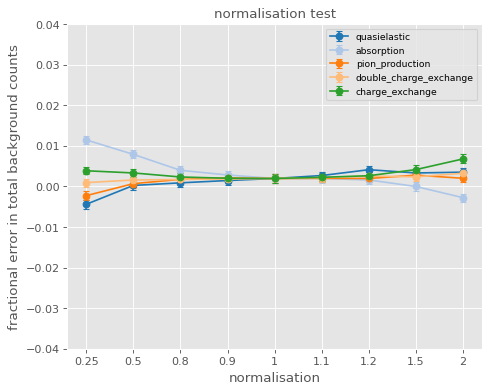

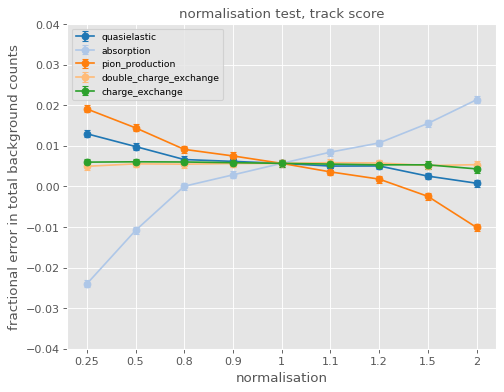

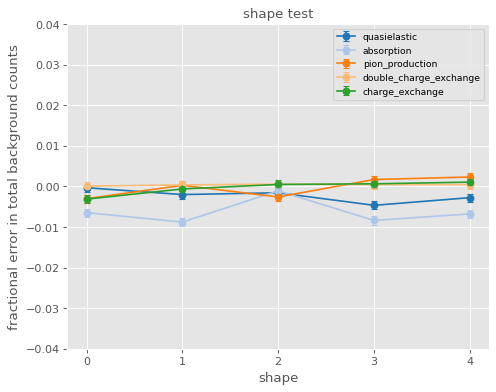

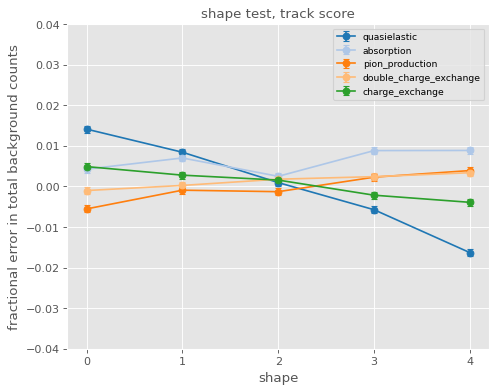

In [66]:
with Plots.PlotBook("test/region_fit_cross_checks_1GeV/background_fractional_err.pdf", True) as book:
    BackgroundPerformanceCheck("test/region_fit_cross_checks_1GeV/normalisation_test/", "charge_exchange", model)
    Plots.plt.title("normalisation test")
    Plots.plt.ylim(-0.04, 0.04)
    book.Save()

    BackgroundPerformanceCheck("test/region_fit_cross_checks_1GeV/normalisation_test_track_score/", "charge_exchange", model)
    Plots.plt.title("normalisation test, track score")
    Plots.plt.ylim(-0.04, 0.04)
    book.Save()

    BackgroundPerformanceCheck("test/region_fit_cross_checks_1GeV/shape_test/", "charge_exchange", model)
    Plots.plt.title("shape test")
    Plots.plt.ylim(-0.04, 0.04)
    Plots.plt.xlabel("shape")
    book.Save()

    BackgroundPerformanceCheck("test/region_fit_cross_checks_1GeV/shape_test_track_score/", "charge_exchange", model)
    Plots.plt.title("shape test, track score")
    Plots.plt.ylim(-0.04, 0.04)
    Plots.plt.xlabel("shape")
    book.Save()

# cross check summary

In [53]:
def PredictedCountsSummary(directories, test, models, toy_template):
    tables = {}
    for model in models:
        results_files = [i for i in cross_section.os.listdir(directories[model]) if "dill" in i]

        target_map = {
            "_abs" : 'absorption',
            "_quasi" : 'quasielastic',
            "_cex" : 'charge_exchange',
            "_dcex" : 'double_charge_exchange',
            "_pip" : 'pion_production'
        }

        results_normal = {[target_map[t] for t in target_map if t in f][0] : cross_section.LoadObject(directories[model] + f) for f in results_files}

        max_sys = {}
        max_all = {}
        for k, v in results_normal.items():
            fractional_err, fractional_err_unc = NormalisationFractionalError(v["results"], v["true_counts"], models[model], toy_template)
            if test == "normalisation":
                max_sys[k] = abs(fractional_err[[0.8, 1.2]]).max(1)
            max_all[k] = abs(fractional_err).max(1)

        tables[model] = {"sys" : pd.DataFrame(max_sys), "all" : pd.DataFrame(max_all)}
    return tables

def BackgroundSubtractionSummary(directories, test, models, toy_template, signal_process):
    tables = {}
    for model in models:
        results_files = [i for i in cross_section.os.listdir(directories[model]) if "dill" in i]

        target_map = {
            "_abs" : 'absorption',
            "_quasi" : 'quasielastic',
            "_cex" : 'charge_exchange',
            "_dcex" : 'double_charge_exchange',
            "_pip" : 'pion_production'
        }

        results_normal = {[target_map[t] for t in target_map if t in f][0] : cross_section.LoadObject(directories[model] + f) for f in results_files}

        max_sys = {}
        max_all = {}
        for k, v in results_normal.items():
            (s_fe, _), (b_fe, _) = BSFractionalError(models[model], toy_template, v, "charge_exchange")
            fractional_err = {"background_subtracted" : s_fe, "background" : b_fe}
            fractional_err = pd.DataFrame(fractional_err, pd.Series((v["results"].keys()))).T
            if test == "normalisation":
                max_sys[k] = abs(fractional_err[[0.8, 1.2]]).max(1)
            max_all[k] = abs(fractional_err).max(1)

        tables[model] = {"sys" : pd.DataFrame(max_sys), "all" : pd.DataFrame(max_all)}
    return tables


In [67]:
models = {
    "normal" : cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, None, False, None, False),
    "track_score" : cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, mean_track_score_bins, False, None, False)
    }

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [72]:
test = "shape"
signal_process = "charge_exchange"

In [73]:
directories = {
    "normal" : f"test/region_fit_cross_checks_1GeV/{test}_test/",
    "track_score" : f"test/region_fit_cross_checks_1GeV/{test}_test_track_score/",
    }

tables = BackgroundSubtractionSummary(directories, test, models, toy_template, signal_process)

In [ ]:
print(tables)

In [75]:
for model in tables:
    for t in tables[model]:
        tables[model][t].style.to_latex(f"{directories[model]}_results_{model}_{t}_bkg.tex")
        tables[model][t].max(1).to_latex(f"{directories[model]}_results_{model}_{t}_bkg.tex")

/tmp/ipykernel_13884/3507545537.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tables[model][t].max(1).to_latex(f"{directories[model]}_results_{model}_{t}_bkg.tex")


# Computing $KE^{fit}_{int}$

In [14]:
# toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1))), smearing = True)
display(toy_observed.df.head())

,KE_init,KE_int,z_int,inclusive_process,exclusive_process,KE_int_smeared,KE_init_smeared,z_int_smeared,absorption,charge_exchange,...,beam_selection_mask,reco_regions_absorption,reco_regions_charge_exchange,reco_regions_single_pion_production,reco_regions_pion_production,truth_regions_absorption,truth_regions_charge_exchange,truth_regions_single_pion_production,truth_regions_pion_production,mean_track_score
0,891.315441,736.201402,71.0,total_inelastic,pion_production,743.184880,898.410005,70.778292,False,False,...,False,False,False,True,False,False,False,False,True,0.236870
1,841.505644,744.489148,44.5,total_inelastic,quasielastic,723.558700,821.457130,44.528440,False,False,...,False,True,False,False,False,False,False,True,False,0.684168
2,785.987938,631.485068,71.5,total_inelastic,absorption,581.923554,737.770693,72.190701,True,False,...,False,True,False,False,False,True,False,False,False,0.947994
3,902.152978,789.273232,51.5,total_inelastic,absorption,732.744631,846.069206,51.909690,True,False,...,False,False,False,True,False,True,False,False,False,0.574450
4,850.854871,778.748203,33.0,total_inelastic,absorption,773.493877,845.561731,32.863315,True,False,...,False,True,False,False,False,True,False,False,False,0.690454


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

counts_matrix=[[8463, 5, 2086, 401], [4281, 594, 682, 164], [6213, 69, 8513, 1081], [2629, 193, 2259, 831]]

total_count_actual, total_count, total_count_err=(38464, 38453.49209334142, 489.1448673382426)

$mu_0$    $mu_1$    $mu_2$   $mu_3$
value  0.008886  0.008339  0.009001  0.00964
error  0.000217  0.000345  0.000242  0.00062

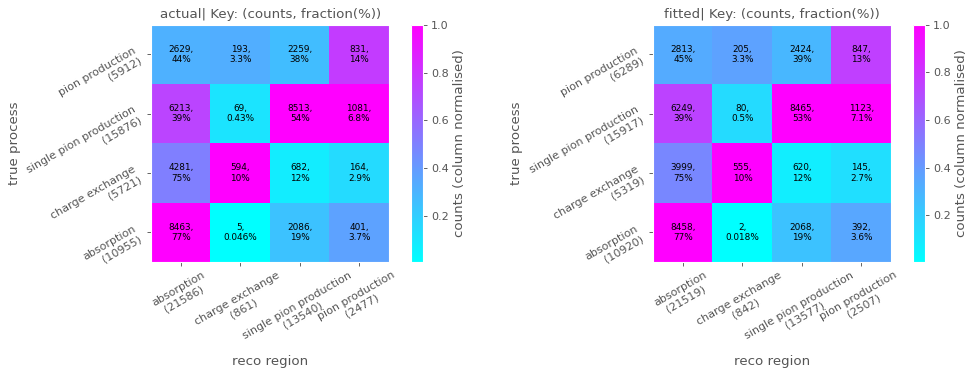

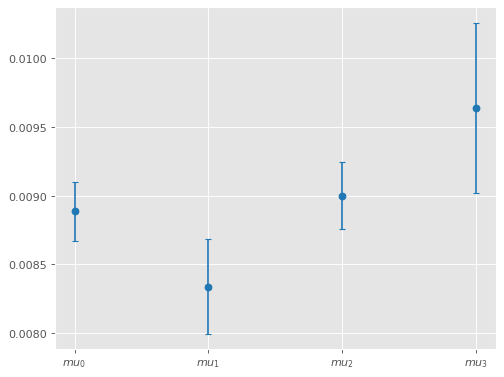

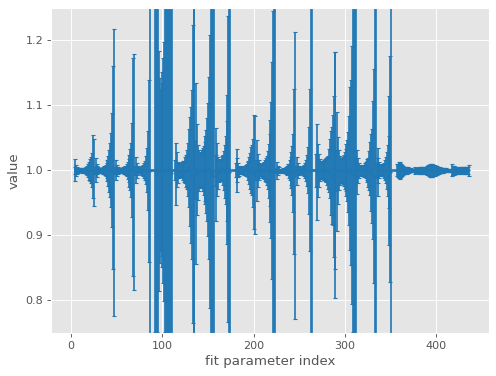

In [15]:
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins)

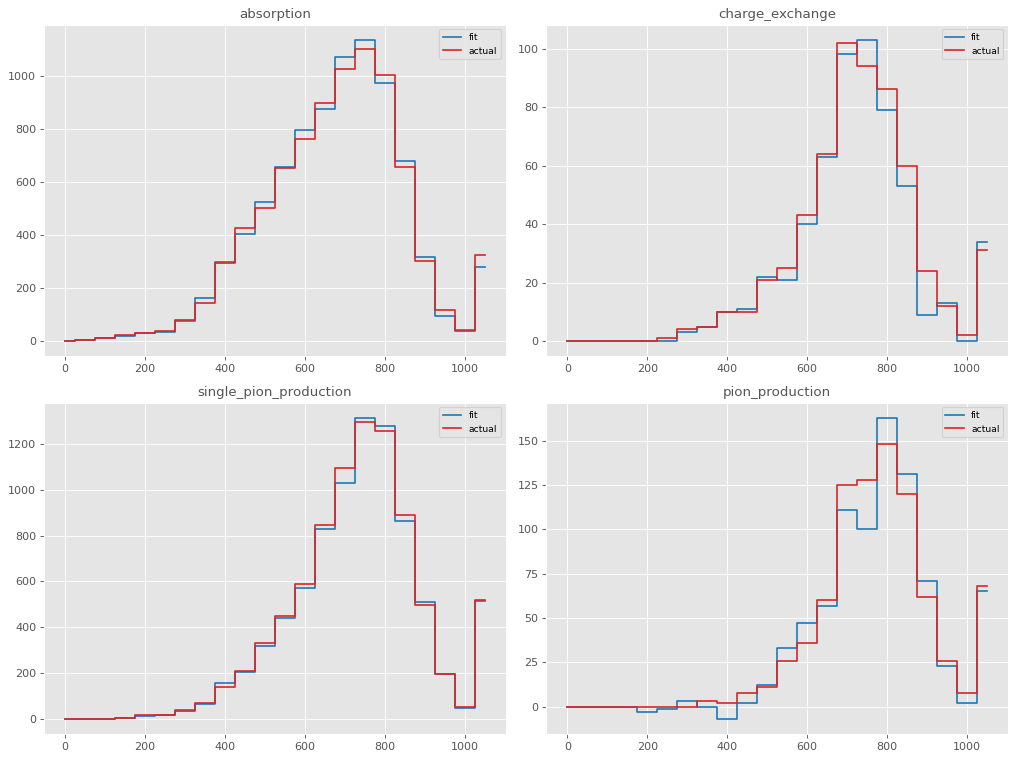

In [17]:
postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)
KE_int_prediction = SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

n = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, None)

n_fit = []
for i, (n_c, lambda_c) in enumerate(zip(n, KE_int_prediction.model_yields)):
    # print(i, n_c, lambda_c)
    n_c_fit = n_c
    for j, s in enumerate(lambda_c):
        if j == i: continue
        n_c_fit = n_c_fit - s
    n_fit.append(np.array(n_c_fit.astype(int)))

actual = [cross_section.EnergySlice.CountingExperiment(
    toy_observed.df.KE_int_smeared,
    toy_observed.df.KE_init_smeared,
    (toy_observed.df.z_int_smeared < 0) | (toy_observed.df.z_int_smeared > 700),
    toy_observed.reco_regions[l] & toy_observed.truth_regions[l] & toy_observed.df.beam_selection_mask,
    energy_slice)[2] for l in toy_observed.truth_region_labels]

# n_fit_template = [KE_int_prediction.model_yields[i][i] for i in range(len(KE_int_prediction.model_yields))]

energy_bins = np.sort(np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width))
for i in Plots.MultiPlot(len(n_fit)):
    Plots.Plot(energy_bins[::-1], n_fit[i], label = "fit", color = "C0", marker = "x", newFigure = False, style = "step")
    Plots.Plot(energy_bins[::-1], actual[i], label = "actual", color = "C6", marker = "x", title = toy_observed.truth_region_labels[i], newFigure = False, style = "step")

['absorption', 'charge_exchange', 'single_pion_production', 'pion_production']

signal: charge_exchange

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1577: RuntimeWarning: divide by zero encountered in divide
  ratio = self.y1 / self.y2
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1582: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2)


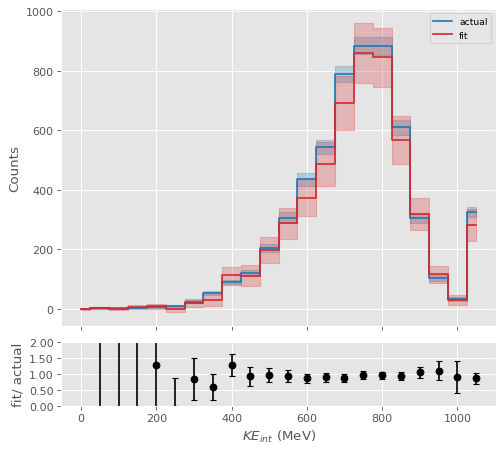

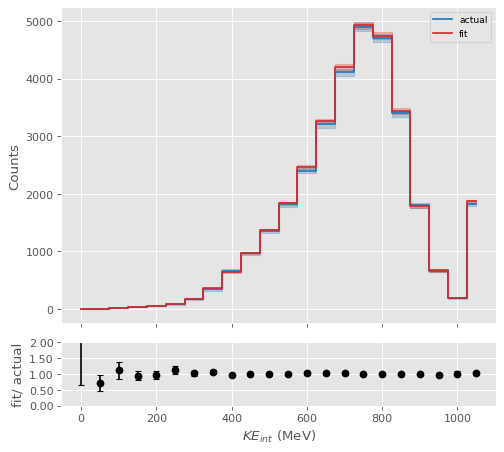

In [18]:
def PlotPrefitPostFit(prefit, prefit_err, postfit, postfit_err):
    with Plots.RatioPlot(energy_bins[::-1], postfit, prefit, postfit_err, prefit_err, "$KE_{int}$ (MeV)", "fit/ actual") as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, color = "C0", label = "actual", style = "step", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, color = "C6", label = "fit", style = "step", ylabel = "Counts", newFigure = False)

print(toy_template.truth_region_labels)
process = "charge_exchange"
print(f"signal: {process}")

N = sum(n)
# print(f"{N=}")

L = np.sum(KE_int_prediction.model_yields, 0)
# print(f"{L=}")

L_err = KE_int_prediction.total_stdev_model_bins[:, :-1] # last entry in the array is the total error for the whole channel (but we want the total error in each process)
L_err = np.sqrt(np.sum(L_err **2, 0)) # quadrature sum across all bins
# print(L_err)

L_var_bkg = sum(L_err[process != np.array(toy_template.truth_region_labels)]**2)
L_bkg = sum(L[process != np.array(toy_template.truth_region_labels)])

# print(f"{L_bkg=}")
# print(f"{L_var_bkg=}")

KE_int_fit = N - L_bkg
KE_int_fit_err = np.sqrt(N + L_var_bkg)

# print(f"{KE_int_fit=}")
# print(f"{KE_int_fit_err=}")

analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed)

actual = {l :  analysis_input.NInteract(energy_slice, analysis_input.exclusive_process[l]) for l in toy_observed.truth_region_labels}
actual_sig = actual[process]
actual_bkg = sum(np.array(list(actual.values()))[process != np.array(toy_template.truth_region_labels)])

# print(f"{actual_sig=}")
# print(f"{actual_bkg=}")

PlotPrefitPostFit(actual_sig, np.sqrt(actual_sig), KE_int_fit, KE_int_fit_err)
PlotPrefitPostFit(actual_bkg, np.sqrt(actual_bkg), L_bkg, np.sqrt(L_var_bkg))

xs_reco_fit_err=array([ 23.66636638,  17.82111865,  12.13622978,   9.59971871,
         8.62913627,   8.50574248,   8.85760466,   9.55265538,
        10.43694225,  11.59320554,  13.28769589,  14.86583797,
        16.88718608,  19.44164011,  23.03958721,  27.98394912,
        35.29228867,  46.44227161,  63.60952502, 129.57968623,
         0.        ,          nan])

(0.0, 327.91921254952456)

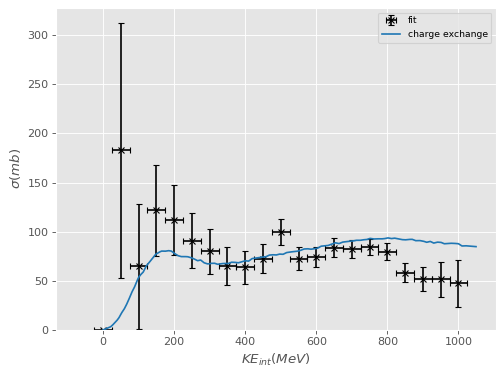

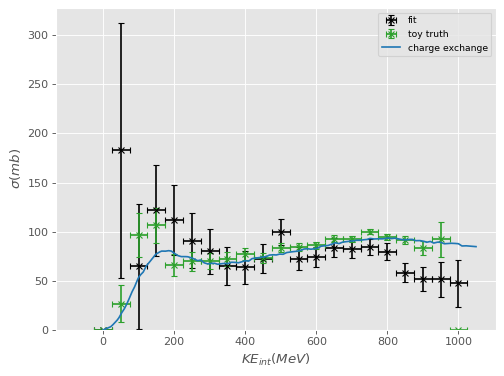

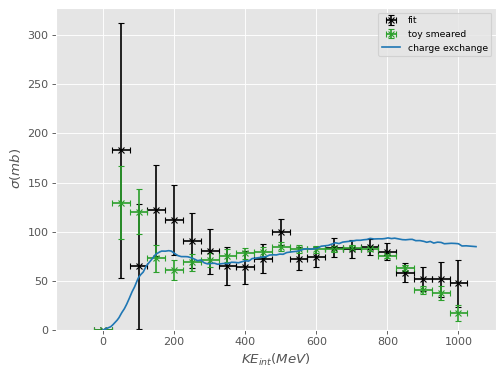

In [32]:
def XSToy(toy : cross_section.Toy, slice_dEdX : np.array, smeared : bool = False):
    KE_int = toy.df.KE_int if smeared is False else toy.df.KE_int_smeared
    KE_init = toy.df.KE_init if smeared is False else toy.df.KE_init_smeared
    outside_tpc = toy.outside_tpc if smeared is False else toy.outside_tpc_smeared

    _, n_interact_inelastic,n_interact_exclusive, n_incident = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice)

    # n_int_inc, n_inc_inc = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.df.inclusive_process != "decay", energy_slice)
    # n_int_ex = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice, interact_only = True)
    xs = cross_section.EnergySlice.CrossSection(n_interact_exclusive[1:], n_interact_inelastic[1:], n_incident[1:], slice_dEdX[1:], energy_slice.width)
    output = {"n_interact_exclusive" : n_interact_exclusive, "n_interact_inclusive" : n_interact_inelastic, "n_incident_inclusive" : n_incident, "xs" : xs[0], "xs_err" : xs[1]}
    return output


geant_xs = cross_section.GeantCrossSections(energy_range = energy_range)
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))

xs_true = XSToy(toy_observed, slice_dEdX, False)
xs_reco = XSToy(toy_observed, slice_dEdX, True) # smeared

xs_reco_fit = cross_section.EnergySlice.CrossSection(np.where(KE_int_fit < 0, 0, KE_int_fit)[1:], xs_reco["n_interact_inclusive"][1:], xs_reco["n_incident_inclusive"][1:], slice_dEdX[1:], energy_slice.width)

# xs_reco_fit_err = np.sqrt(np.array(xs_reco_fit[1]**2 + (KE_int_fit_err * xs_reco_fit[0] / KE_int_fit)**2, dtype = float))
xs_reco_fit_err = np.array(KE_int_fit_err[1:] * xs_reco_fit[0] / KE_int_fit[1:], dtype = float) # fit error accounts for statistical uncertainty as well

print(f"{xs_reco_fit_err=}")

x = energy_slice.pos[1:]

# Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_true["xs"], xerr = energy_slice.width/2, yerr = xs_true["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy truth", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_reco["xs"], xerr = energy_slice.width/2, yerr = xs_reco["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy smeared", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

In [31]:
def weighted_chi_sqr(observed, expected, uncertainties):
    return np.nansum((observed - expected)**2 / uncertainties**2) / len(observed)

sim_curve_interp = cex_toy_generator.interp1d(geant_xs.KE, getattr(geant_xs, process), fill_value = "extrapolate")(x)
weighted_chi_sqrs = {
    "truth": weighted_chi_sqr(xs_true["xs"][:-2], sim_curve_interp, xs_true["xs_err"][:-2]),
    "smeared": weighted_chi_sqr(xs_reco["xs"][:-2], sim_curve_interp, xs_reco["xs_err"][:-2]),
    "fit": weighted_chi_sqr(xs_reco_fit[0][:-1], sim_curve_interp, xs_reco_fit[1][:-1])
}
print(weighted_chi_sqrs)

{'truth': 1.2834386713268517, 'smeared': 20.436367137343048, 'fit': 33.475855250784946}

# Two process model

In [3]:
def TwoSampleKETemplate(toy_template : cross_section.Toy, signal, energy_slices, weights = None):
    signal_mask = toy_template.truth_regions[signal]
    
    templates = []
    for c in toy_template.reco_regions:
        
        templates.append([
            toy_template.NInteract(energy_slices, signal_mask, toy_template.reco_regions[c], weights) + 1,
            toy_template.NInteract(energy_slices, ~signal_mask, toy_template.reco_regions[c], weights) + 1,
            ])
        # analysis_input.NInteract(energy_slices, analysis_input.exclusive_process[s], analysis_input.regions[c], True, analysis_input.weights) + 1
    return templates

def TwoSampleMeanTrackScoreTemplate(toy_template : cross_section.Toy, signal, bins, weights = None):
    templates = []
    signal_mask = toy_template.truth_regions[signal]
    templates = [
        np.histogram(toy_template.df.mean_track_score[signal_mask], bins, weights = weights[signal_mask] if weights is not None else weights)[0],
        np.histogram(toy_template.df.mean_track_score[~signal_mask], bins, weights = weights[~signal_mask] if weights is not None else weights)[0]
    ]
    return np.array(templates)

signal = "charge_exchange"
energy_range = [0, 1000]
energy_slice = cross_section.Slices(50, min(energy_range), max(energy_range), True)

energy_overflow =  np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)

mean_track_score_bins = np.linspace(0, 1, 21, True)

KE_templates = TwoSampleKETemplate(toy_template, signal, energy_slice, None)
mean_track_score_template = TwoSampleMeanTrackScoreTemplate(toy_template, signal, mean_track_score_bins, None)

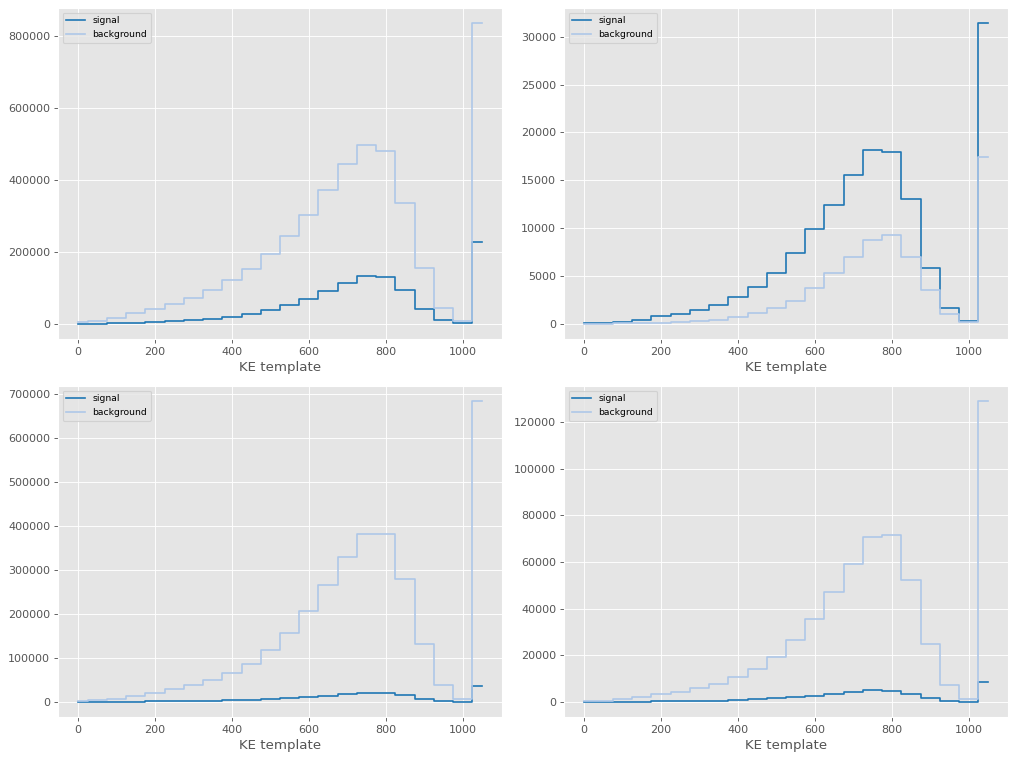

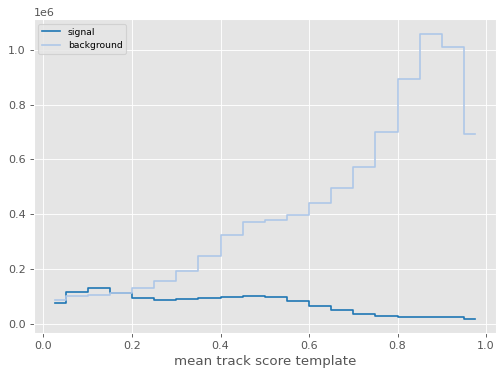

In [4]:
label = ["signal", "background"]
for _, c in Plots.IterMultiPlot(KE_templates):
    for i, s in enumerate(c):
        Plots.Plot(energy_overflow, s, label = label[i], style = "step", newFigure = False, xlabel = "KE template")

Plots.plt.figure()
for i, s in enumerate(mean_track_score_template):
    Plots.Plot(cross_section.bin_centers(mean_track_score_bins), s, style = "step", label = label[i], xlabel = "mean track score template", newFigure = False)

In [5]:
model = cross_section.RegionFit.Model(4, KE_templates, None, False)

In [6]:
analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template)

In [7]:
cross_section.RegionFit.Fit(cross_section.RegionFit.GenerateObservations(analysis_input, energy_slice, None, model), model)

model.config.suggested_init()=[1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-522.01742143])
init_params=None
poi_ind=[0, 1]
parameter=['mu_0', 'mu_1']
bestfit=array([0.99984884, 1.00000527])
uncertainty=array([0.00253469, 0.00053665])
result=FitResults(bestfit=array([0.99984884, 1.00000527]), uncertainty=array([0.00253469, 0.00053665]), labels=['mu_0', 'mu_1'], corr_mat=[[ 1.         -0.72591833]
 [-0.72591833  1.        ]], best_twice_nll=1044.0288024236856, goodness_of_fit=-1, minos_uncertainty={})


FitResults(bestfit=array([0.99984884, 1.00000527]), uncertainty=array([0.00253469, 0.00053665]), labels=['mu_0', 'mu_1'], corr_mat=[[ 1.         -0.72591833]
 [-0.72591833  1.        ]], best_twice_nll=1044.0288024236856, goodness_of_fit=-1, minos_uncertainty={})

In [8]:
def PlotFitResults2Samp(xlabel, model : cross_section.pyhf.Model, toy_template : cross_section.Toy, results, true_counts, pdf : Plots.PlotBook = Plots.PlotBook.null):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    scale_factors = {k : sum(true_counts[k].values()) / sum(toy_template.df.total_inelastic) for k in true_counts}
    x = list(range(len(results)))

    mu = []
    mu_err = []
    for k in results:
        mu.append(results[k].bestfit[0:2] / scale_factors[k])
        mu_err.append(results[k].uncertainty[0:2] / scale_factors[k])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    process_map = {0 : "sig", 1 : "bkg"}

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(2):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{{{process_map[i]}}}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
    Plots.plt.xticks(ticks = x, labels = results.keys())
    Plots.plt.xlabel(xlabel)
    pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(2):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, title = f"$\mu_{{{process_map[i]}}}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()


    true_counts_samp = []
    true_counts_pred_res = []
    true_counts_pred_res_err = []
    for k, v in results.items():
        true_counts_sig = true_counts[k]["charge_exchange"]
        true_counts_bkg = sum([true_counts[k][i] for i in true_counts[k] if i != "charge_exchange"])
        counts_2samp = np.array([true_counts_sig, true_counts_bkg])

        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")

        if any([c["name"] == "mean_track_score" for c in post_fit_pred.model.spec["channels"]]):
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score
        else:
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(0, len(post_fit_pred.model_yields)), "KE_int_postfit")

        true_counts_samp.append(counts_2samp)
        true_counts_pred_res.append(np.sum([np.sum(i, 1) for i in post_fit_pred.model_yields], 0) - counts_2samp)

        true_counts_pred_res_err.append(np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1])
        # true_counts_pred_res[k] = {toy_template.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_template.reco_region_labels))])) - true_counts[k][toy_template.truth_region_labels[j]] for j in range(len(toy_template.truth_region_labels))}


    true_counts_samp = np.array(true_counts_samp).T
    true_counts_pred_res = np.array(true_counts_pred_res).T
    true_counts_pred_res_err = np.array(true_counts_pred_res_err).T

    print(f"{true_counts_samp=}")
    print(f"{true_counts_pred_res=}")

    prefit_counts = [model.main_model.expected_data(np.array(model.config.suggested_init()) * scale_factors[k], return_by_sample = True) for k in scale_factors]

    if "mean_track_score" in model.config.channels:
        prefit_counts = [i[:, :-model.config.channel_nbins["mean_track_score"]] for i in prefit_counts]
    prefit_counts = np.array([np.sum(i, 1) for i in prefit_counts]).T

    print(prefit_counts)

    # plot true process residual
    for i in Plots.MultiPlot(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i], yerr = true_counts_pred_res_err[i], title = f"$N_{{{process_map[i]}}}^{{pred}}$", xlabel = xlabel, ylabel = "residual", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for i in Plots.MultiPlot(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i] / true_counts_samp[i], yerr = true_counts_pred_res_err[i] / true_counts_samp[i], title = f"measured $N_{{{process_map[i]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for i in Plots.MultiPlot(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i] / true_counts_samp[i], yerr = true_counts_pred_res_err[i] / true_counts_samp[i], title = f"$N_{{{process_map[i]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[i], label = "measured", newFigure = False)
        Plots.Plot(x, (prefit_counts[i] - true_counts_samp[i]) / true_counts_samp[i], title = f"$N_{{{process_map[i]}}}$", linestyle = "", marker = "o", color = "k", label = "prefit", newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    Plots.plt.figure()
    for i in range(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i] / true_counts_samp[i], yerr = true_counts_pred_res_err[i] / true_counts_samp[i], label = f"${process_map[i]}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        plt.ylim(-1, 1)
    Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()


In [11]:
folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}

for target in folder:
    print(target)

    results = {}
    true_counts = {}
    expected_mus = {}
    directory = f"test/region_fit_tests_2samp/"
    scales = {
        'absorption': 1,
        'quasielastic': 1,
        'charge_exchange': 1,
        'double_charge_exchange': 1,
        'pion_production': 1
        }
    config = CreateConfig(scale_factors = scales, seed = 1, events = 1E6)
    for i in [0.25, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2]:
        scales[target] = i
        results[i], true_counts[i], expected_mus[i] = ModifiedConfigTest(config, energy_slice, model, toy_template, None, None)
        clear_output()
        print(target)
    
    cross_section.SaveObject(f"{directory}fit_results_{folder[target]}.dill", {"results" : results, "true_counts" : true_counts, "expected_mus" : expected_mus}) # keep results for future reference
    with Plots.PlotBook(f"{directory}fit_results_{folder[target]}.pdf", True) as pdf:
      PlotFitResults2Samp(f"{target} normalisation", model, toy_template, results, true_counts, pdf)
    Plots.plt.close("all")

pion_production

pdf test/region_fit_tests_2samp/fit_results_pip.pdf has been opened


true_counts_samp=array([[167937, 160128, 152579, 149797, 147544, 145441, 143127, 136687,
        127142],
       [825070, 832879, 840428, 843210, 845463, 847566, 849880, 856320,
        865865]])

true_counts_pred_res=array([[-7965.48261865, -5610.6318463 , -2241.55669965, -1484.78224257,
         -501.77544377,   499.75263454,  1432.0571449 ,  3060.36798682,
         6736.46990761],
       [ 7965.49708698,  5610.63191947,  2241.5579933 ,  1484.78216653,
          501.77549875,  -499.75260124, -1432.0571188 , -3060.31264888,
        -6736.59918402]])

[[146004.42716327 146004.42716327 146004.42716327 146004.42716327
  146004.42716327 146004.42716327 146004.42716327 146004.42716327
  146004.42716327]
 [847014.77527105 847014.77527105 847014.77527105 847014.77527105
  847014.77527105 847014.77527105 847014.77527105 847014.77527105
  847014.77527105]]

pdf test/region_fit_tests_2samp/fit_results_pip.pdf has been closed


# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
    if mean_track_score_bins is not None:
        toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
    return toy_observed_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.RegionFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels)
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_template, toy_template, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_template, toy_alt, pdf_vary)
pdf_vary.close()